# Application of FRANKEN-Z to Real Data

## Part 1

This notebook demonstrates an application of FRANKEN-Z to S16A **Hyper Suprime-Cam (HSC) Subaru Strategic Program (SSP) survey data**. As the training data includes $\sim\!400,000$ objects that have been **inhomogeneously sampled** (cobbled together from various surveys) with **varying errors** (stochastic backgrounds) and **depths** (collected from wide, deep, and ultra-deep fields) along with **multiple flux measurements** (PSF, Cmodel, and fiber/aperture quantities) and **randomly censored data** (from failed extractions and missing coverage), modeling these data provides many new challenges and opportunities.

In this portion, we conduct preliminary tests to determine what set of features appears most relevant to our purposes, where we compare performance on the individual object level as well as the population level. This brings up practical issues of such as the "curse of dimensionality" and deciding on proper comparative diagnostics.

# Setup

Let's initialize the environment.

In [1]:
import sys # system commands
from scipy import stats # statistics
from scipy import special # special functions
from astropy.io import fits # reading fits files

# FRANKEN-Z
import frankenz as fz

%pylab
%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


Importing FRANKEN-Z config files...

In [2]:
# master config file
config=fz.ReadParams('config/frankenz.config') 

# import filters
filt=fz.ReadFilters(config.params['FILTERS'],path=config.params['FILTER_PATH'])
Nf=filt.NFILTER

# initialize redshift dictionary
rdict=fz.RedshiftDict(config.CONFIG_REDSHIFT.params)

# add names so easier to reference later
rdict.sig_dict=rdict.lze_dict
rdict.sig_width=rdict.lze_width
rdict.delta=rdict.dlz_highres
rdict.grid=rdict.lzgrid_highres
rdict.Ngrid=rdict.Nz_highres

# initialize supplementary dictionaries
mdict=fz.PDFDict(config.CONFIG_MAG.params) # magnitude
cdict=fz.PDFDict(config.CONFIG_COLOR.params) # color

Importing HSC data...

In [3]:
# load observed data
data=fits.open('/Users/Josh/Dropbox/HSC/HSC_photoz/catalogs/hsc_s16a_combined_specz_highq_clean_errsim_train_v1.fits')[1].data
print 'Training objects:',len(data)

Training objects: 373432


The HSC catalog contains a wide collection of training objects and photometry measured using several different outputs. We need to parse through which (combination) of these will be most useful for our purposes. Just adding more and more features into our results doesn't necessarily imporve our results if they don't add significantly more information, and can in fact degrade our predictions if they mostly add measurement noise.  In addition, the "curse of dimensionality" makes our nearest-neighbor search significantly slower, forcing us to subsample the dimensions.

Before we get into that though, we need to initialize the dust attenuation corrections to our photometry (due to galactic extinction). These have been computed according to [SFD](http://www.adsabs.harvard.edu/abs/1998ApJ...500..525S) I believe.

In [4]:
aphot=10**(-0.4*c_[data['a_g'],data['a_r'],data['a_i'],data['a_z'],data['a_y']])
print 'Median correction:',median(aphot,axis=0)

Median correction: [ 0.94042301  0.95740581  0.96941328  0.97632635  0.97976404]


Now let's initialize the [**PSF flux**](http://www.sdss.org/dr12/algorithms/magnitudes/#mag_psf), which measures the flux by fitting a PSF model to the object.

In [5]:
flux_psf=c_[data['gflux_psf'],data['rflux_psf'],data['iflux_psf'],data['zflux_psf'],data['yflux_psf']]*aphot
err_psf=c_[data['gflux_psf_err'],data['rflux_psf_err'],data['iflux_psf_err'],data['zflux_psf_err'],data['yflux_psf_err']]*aphot
err_psf_wide=c_[data['gflux_psf_err_wide'],data['rflux_psf_err_wide'],data['iflux_psf_err_wide'],
                data['zflux_psf_err_wide'],data['yflux_psf_err_wide']]*aphot
mask_psf=(err_psf>0.)&isfinite(err_psf)
print 'Objects with missing values:',(mask_psf.sum(axis=1)<Nf).sum()

Objects with missing values: 3


Note that in addition to the reported errors, there are also **"wide-depth" emulated errors**. These are used to ensure that performance on testing folds are homogenized to the same depth, which is necessary to give accurate forecasts to objects with a different set of noise properties.

Now let's initialize the [**cModel flux**](http://www.sdss.org/dr12/algorithms/magnitudes/#cmodel), which fits a combined de Vaucouleurs and exponential profile. The combined fit (and each of the components) and below.

In [6]:
flux_cmodel=c_[data['gcmodel_flux'],data['rcmodel_flux'],data['icmodel_flux'],data['zcmodel_flux'],data['ycmodel_flux']]*aphot
err_cmodel=c_[data['gcmodel_flux_err'],data['rcmodel_flux_err'],data['icmodel_flux_err'],
           data['zcmodel_flux_err'],data['ycmodel_flux_err']]*aphot
err_cmodel_wide=c_[data['gcmodel_flux_err_wide'],data['rcmodel_flux_err_wide'],data['icmodel_flux_err_wide'],
                data['zcmodel_flux_err_wide'],data['ycmodel_flux_err_wide']]*aphot
mask_cmodel=(err_cmodel>0.)&isfinite(err_cmodel)
print 'Objects with missing values:',(mask_cmodel.sum(axis=1)<Nf).sum()

Objects with missing values: 0


In [7]:
flux_cmodel_dev=c_[data['gcmodel_dev_flux'],data['rcmodel_dev_flux'],data['icmodel_dev_flux'],
                   data['zcmodel_dev_flux'],data['ycmodel_dev_flux']]*aphot
err_cmodel_dev=c_[data['gcmodel_dev_flux_err'],data['rcmodel_dev_flux_err'],data['icmodel_dev_flux_err'],
           data['zcmodel_dev_flux_err'],data['ycmodel_dev_flux_err']]*aphot
err_cmodel_dev_wide=c_[data['gcmodel_dev_flux_err_wide'],data['rcmodel_dev_flux_err_wide'],data['icmodel_dev_flux_err_wide'],
                data['zcmodel_dev_flux_err_wide'],data['ycmodel_dev_flux_err_wide']]*aphot
mask_cmodel_dev=(err_cmodel_dev>0.)&isfinite(err_cmodel_dev)
print 'Objects with missing values:',(mask_cmodel_dev.sum(axis=1)<Nf).sum()

Objects with missing values: 0


In [8]:
flux_cmodel_exp=c_[data['gcmodel_exp_flux'],data['rcmodel_exp_flux'],data['icmodel_exp_flux'],
                   data['zcmodel_exp_flux'],data['ycmodel_exp_flux']]*aphot
err_cmodel_exp=c_[data['gcmodel_exp_flux_err'],data['rcmodel_exp_flux_err'],data['icmodel_exp_flux_err'],
           data['zcmodel_exp_flux_err'],data['ycmodel_exp_flux_err']]*aphot
err_cmodel_exp_wide=c_[data['gcmodel_exp_flux_err_wide'],data['rcmodel_exp_flux_err_wide'],data['icmodel_exp_flux_err_wide'],
                data['zcmodel_exp_flux_err_wide'],data['ycmodel_exp_flux_err_wide']]*aphot
mask_cmodel_exp=(err_cmodel_exp>0.)&isfinite(err_cmodel_exp)
print 'Objects with missing values:',(mask_cmodel_exp.sum(axis=1)<Nf).sum()

Objects with missing values: 0


Now let's initialize the [**psf-matched aperture flux**](http://www.sdss.org/dr12/algorithms/magnitudes/#mag_model), which matches the psf across bands and then extracts the flux using a fixed aperture. We use 1.5 arcsec aperture photometry with a target PSF=1.1 arcsec. As our original flux uncertainties are underestimated, we take the uncertainties computed from 1.5 arcsec aperture photometry *without* PSF matching as very rough proxy.

Initializing afterburner flux...

In [9]:
flux_afterburner=c_[data['gparent_flux_convolved_2_1'],data['rparent_flux_convolved_2_1'],data['iparent_flux_convolved_2_1'],
                   data['zparent_flux_convolved_2_1'],data['yparent_flux_convolved_2_1']]*aphot
err_afterburner=c_[data['gflux_aperture15_err'],data['rflux_aperture15_err'],data['iflux_aperture15_err'],
                   data['zflux_aperture15_err'],data['yflux_aperture15_err']]*aphot

mask_afterburner=(err_afterburner>0.)&isfinite(err_afterburner)
print 'Objects with missing values:',(mask_afterburner.sum(axis=1)<Nf).sum()

Objects with missing values: 3


One additional photometric quantity that might be useful (but is not used here) is the [**galaxy shape moments **] derived through the [SDSS algorithm](https://www.sdss3.org/dr8/algorithms/classify.php#photo_stokes). This also allows us to compute the **determinant size**.

Initializing shape information... (not currently used)

In [10]:
shape_sdss=c_[data['gshape_sdss_11'],data['gshape_sdss_12'],data['gshape_sdss_22'],
              data['rshape_sdss_11'],data['rshape_sdss_12'],data['rshape_sdss_22'],
              data['ishape_sdss_11'],data['ishape_sdss_12'],data['ishape_sdss_22'],
              data['zshape_sdss_11'],data['zshape_sdss_12'],data['zshape_sdss_22'],
              data['yshape_sdss_11'],data['yshape_sdss_12'],data['yshape_sdss_22']]
err_sdss=c_[data['gshape_sdss_err_11_11'],data['gshape_sdss_err_12_12'],data['gshape_sdss_err_22_22'],
            data['rshape_sdss_err_11_11'],data['rshape_sdss_err_12_12'],data['rshape_sdss_err_22_22'],
            data['ishape_sdss_err_11_11'],data['ishape_sdss_err_12_12'],data['ishape_sdss_err_22_22'],
            data['zshape_sdss_err_11_11'],data['zshape_sdss_err_12_12'],data['zshape_sdss_err_22_22'],
            data['yshape_sdss_err_11_11'],data['yshape_sdss_err_12_12'],data['yshape_sdss_err_22_22']]
err_sdss_wide=c_[data['gshape_sdss_err_11_11_wide'],data['gshape_sdss_err_12_12_wide'],data['gshape_sdss_err_22_22_wide'],
                 data['rshape_sdss_err_11_11_wide'],data['rshape_sdss_err_12_12_wide'],data['rshape_sdss_err_22_22_wide'],
                 data['ishape_sdss_err_11_11_wide'],data['ishape_sdss_err_12_12_wide'],data['ishape_sdss_err_22_22_wide'],
                 data['zshape_sdss_err_11_11_wide'],data['zshape_sdss_err_12_12_wide'],data['zshape_sdss_err_22_22_wide'],
                 data['yshape_sdss_err_11_11_wide'],data['yshape_sdss_err_12_12_wide'],data['yshape_sdss_err_22_22_wide']]
mask_sdss=(err_sdss>0.)&isfinite(err_sdss)

size_sdss=shape_sdss[:,[0,3,6,9,12]]*shape_sdss[:,[2,5,8,11,14]]-shape_sdss[:,[1,4,7,10,13]]**2
size_sdss_err=((shape_sdss[:,[0,3,6,9,12]]*err_sdss[:,[2,5,8,11,14]])**2
               +(err_sdss[:,[0,3,6,9,12]]*shape_sdss[:,[2,5,8,11,14]])**2
               +(2*shape_sdss[:,[1,4,7,10,13]]*err_sdss[:,[1,4,7,10,13]])**2)**0.5
size_sdss_err_wide=((shape_sdss[:,[0,3,6,9,12]]*err_sdss_wide[:,[2,5,8,11,14]])**2
                    +(err_sdss_wide[:,[0,3,6,9,12]]*shape_sdss[:,[2,5,8,11,14]])**2
                    +(2*shape_sdss[:,[1,4,7,10,13]]*err_sdss_wide[:,[1,4,7,10,13]])**2)**0.5

print 'Objects with missing values:',(mask_sdss.sum(axis=1)<Nf*3).sum()

Objects with missing values: 25286


Of course, a photometric redshift (photo-z) algorithm wouldn't really be complete without properly extracting the set of **target redshifts** we're using to predict things. In this catalog, I've included redshifts from a variety of sources. These are:
- **spec-z's** from BOSS, DEEP2, VIPERS, VVDS, GAMA, WIGGLEZ, UDSZ, zCOSMOS (with some private redshifts), FMOS-COSMOS, and 3DHST,
- **prism-z's** from PRIMUS,
- **grism-z's** from 3DHST,
- **photo-z's** from COSMOS2015 and 3DHST (with quality cuts)

In [11]:
z,ze,zt,zs=data['redshift'],data['redshift_err'],data['redshift_type'],data['redshift_source']
ze[ze<0]=0.

Lastly, we want to initialize some general catalog features. These include mapping our results to **asinh magnitudes** (i.e. [Luptitudes](http://www.sdss.org/dr12/algorithms/magnitudes/#asinh)), extracting depth markers (for data taken at wide, deep, and ultra-deep depths), and finally a series of cross-validation folds and magnitude/color weights (to facilitate accurate redshift projections to the wide-depth sample of interest).

In [12]:
Nobs=len(data) # number of objects
flux_zeropoint=10**(-0.4*-23.9) # AB magnitude zeropoint
skynoise=median(err_cmodel,axis=0) # "background" skynoise (used for consistent mappings)
mag_cmodel,magerr_cmodel=fz.asinh_mag_map(flux_cmodel,err_cmodel_wide,skynoise,zeropoint=flux_zeropoint) # Luptitude mapping
depth=data['depth'] # depth of sample
cv=data['crossval_sample'] # cross-validation fold
cv_weights=data['crossval_weights'] # magnitude-color weights

Nfolds=max(cv)

FRANKEN-Z utilizes a set of discretized dictionaries to speed up computation, so we now map our magnitudes/redshifts onto these. 

In [13]:
lzidx,lzeidx=rdict.fit(log(1+z),ze/(1+z)) # discretize redshifts
magidx,mageidx=mdict.fit(mag_cmodel,magerr_cmodel) # discretize magnitudes

## Diagnostics

Let's first make some preliminary plots to see what we're dealing with.

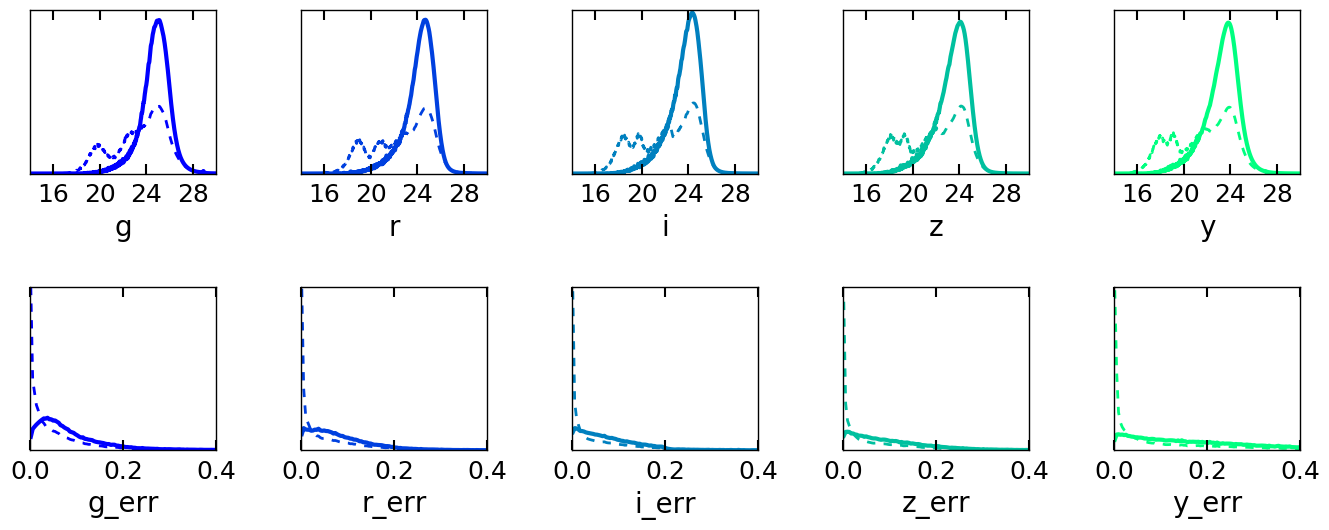

In [14]:
# plotting magnitude distribution
fcolors=get_cmap('winter')(linspace(0,1,Nf)) # filter colors
figure(figsize=(14,6))
for i in xrange(Nf):
    subplot(2,Nf,i+1)
    mag_pdf=fz.pdf_kde_dict(mdict.sig_dict,mdict.sig_width,magidx[:,i],mageidx[:,i],ones(Nobs),
                            mdict.grid,mdict.delta,mdict.Ngrid)
    plot(mdict.grid,mag_pdf,lw=2,color=fcolors[i],linestyle='--')
    mag_pdf=fz.pdf_kde_dict(mdict.sig_dict,mdict.sig_width,magidx[:,i],mageidx[:,i],cv_weights,
                            mdict.grid,mdict.delta,mdict.Ngrid)
    plot(mdict.grid,mag_pdf,lw=3,color=fcolors[i])
    xlim([14,30])
    yticks([])
    xticks(arange(16,30,4),fontsize=18)
    xlabel(filt.filters[i],fontsize=20)
    tight_layout()
    subplot(2,Nf,i+1+Nf)
    h,bins=histogram(magerr_cmodel[:,i],normed=True,range=[0,0.4],bins=100)
    plot((bins[:-1]+bins[1:])/2.,h,lw=2,color=fcolors[i],linestyle='--')
    h,bins=histogram(magerr_cmodel[:,i],normed=True,range=[0,0.4],bins=100,weights=cv_weights)
    plot((bins[:-1]+bins[1:])/2.,h,lw=3,color=fcolors[i])
    xticks(linspace(0,0.4,3),fontsize=18)
    xlabel(filt.filters[i]+'_err',fontsize=20)
    yticks([])
    tight_layout()

The weights appear to do a good job of matching the desired distribution.

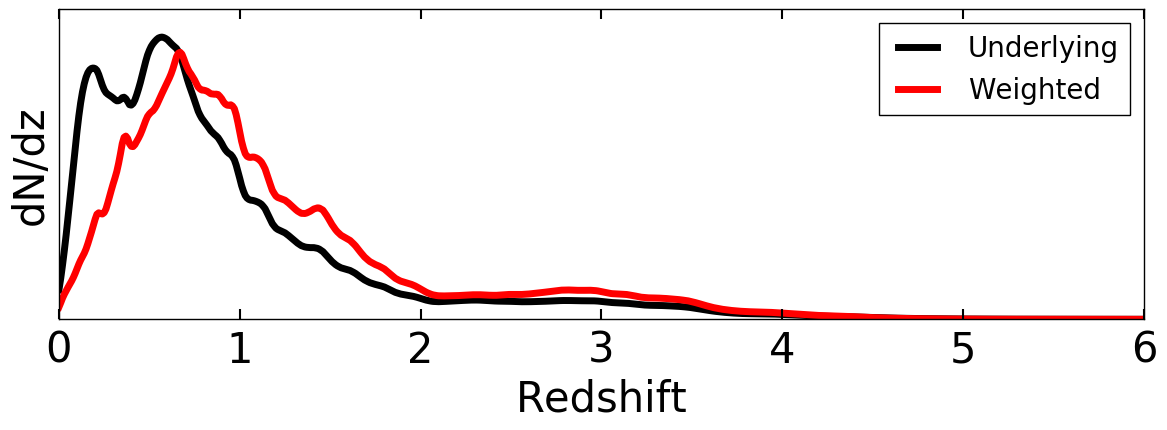

In [15]:
figure(figsize=(14,4))

z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx,lzeidx,ones(Nobs),rdict.grid,rdict.delta,rdict.Ngrid)
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx,lzeidx,cv_weights,rdict.grid,rdict.delta,rdict.Ngrid)
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='red',label='Weighted')

legend(fontsize=20)
xlabel('Redshift')
yticks([])
ylabel('dN/dz')

There's clearly leftover structure in the weighted $dN/dz$, however. Breaking things down by sample, we can figure out where this arises.

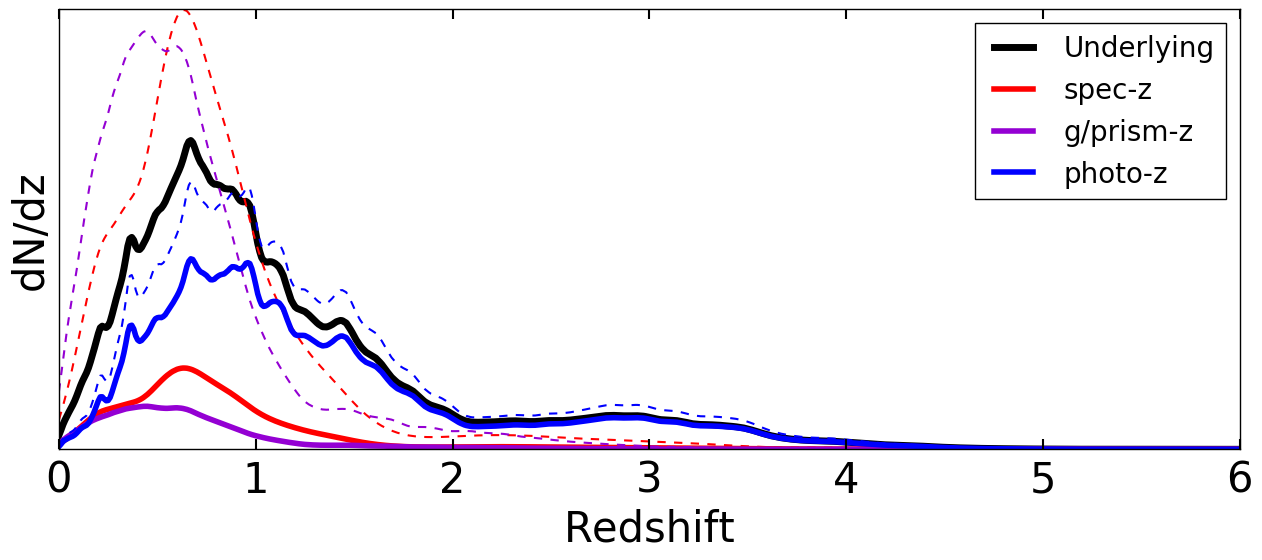

In [16]:
figure(figsize=(14,6))

wcv_t=cv_weights #*(mag_cmodel[:,2]<23.5)

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx,lzeidx,wcv_t,rdict.grid,rdict.delta,rdict.Ngrid)
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf*wcv_t.sum(),lw=5,color='black',label='Underlying')

ztypes=['spec-z','g/prism-z','photo-z']
zcolors=['red','darkviolet','blue']
for i in xrange(3):
    w=wcv_t*(zt==(i+1))
    z_pdf_t=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx,lzeidx,w,rdict.grid,rdict.delta,rdict.Ngrid)
    z_pdf_t=z_pdf_t[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
    z_pdf_t=interp(rdict.zgrid_out,rdict.zgrid,z_pdf_t)
    z_pdf_t/=z_pdf_t.sum()
    plot(rdict.zgrid_out,z_pdf_t*w.sum(),lw=4,color=zcolors[i],label=ztypes[i])
    plot(rdict.zgrid_out,z_pdf_t*wcv_t.sum(),lw=1.5,color=zcolors[i],linestyle='--')

xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
yticks([])
ylabel('dN/dz')

Almost all of the structure is due to the photo-z's. We will return to this in part 2 of the application notebooks, but for now let's just move on.

# Initial Tests

We first run some initial tests using each individual set of fluxes to see which (if any) appears to perform best. Since we're just trying to gain some intuition, we'll just choose one of the original folds to run some tests on.

In [14]:
train_sel=cv<5
test_sel=cv==5
lzidx_train,lzeidx_train=lzidx[train_sel],lzeidx[train_sel]
lzidx_test,lzeidx_test=lzidx[test_sel],lzeidx[test_sel]

Ntrain=train_sel.sum()
Ntest=test_sel.sum()
print 'Ntrain:',Ntrain
print 'Ntest:',Ntest

Ntrain: 298766
Ntest: 74666


We're clearly in a regime where we're not limited by strong statistical fluctuations, so this should be fine.

### Cmodel Fluxes

In [17]:
p1,v1,m1=flux_cmodel[train_sel],square(err_cmodel[train_sel]),mask_cmodel[train_sel] # full depth
p2,v2,m2=flux_cmodel[test_sel],square(err_cmodel_wide[test_sel]),mask_cmodel[test_sel] # wide depth
e1,e2=sqrt(v1+square(0.01*p1)),sqrt(v2+square(0.01*p2)) # add 1% error floor

frankenz=fz.FRANKENZ(N_members=25)
model_obj,model_Nobj,model_ll,model_Nbands=frankenz.predict(p1,e1,m1,p2,e2,m2)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!


Now that we have a collection of training objects ("models") and weights, the simplest thing we can do to generate redshift predictions is just stack the underlying kernels.

In [18]:
# generate redshifts
model_llmin=empty(Ntest).astype(float)
lzpdf=empty((Ntest,rdict.Nz))
zpdf=empty((Ntest,rdict.Nz_out))
model_levidence=empty(Ntest)

for i in xrange(Ntest):
    if i%1000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    model_llmin[i]=ll.min() # minimum value (for scaling)
    w=exp(-0.5*(ll-model_llmin[i])) # transform to scaled likelihood weights
    model_levidence[i]=-2*log(w.sum())+model_llmin[i] # -2ln(Evidence)
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train[midx],lzeidx_train[midx],w,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[i]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# normalize PDFs   
zpdf=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out)

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 Resampling PDFs...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!


PDFs are hard to compare *a priori* (although see some of the analysis in part 2). An simpler approach is to compute some small set of **summary statistics** such as point estimates (mean, median mode) or confidence intervals. FRANKEN-Z contains a method to compute some PDF summary statistics that makes this relatively easy.

In [19]:
# compute point estimates
zpoints=fz.pdfs_summary_statistics(rdict.zgrid_out,zpdf) # mean, med, mode, l68, h68, l95, h95, std, conf

Computing PDF quantities...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!


Let's now take advantage of some of FRANKEN-Z's built-in plotting utilities to examine the results.

C:\Users\Josh\Anaconda2\lib\site-packages\scipy\stats\morestats.py:1685: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


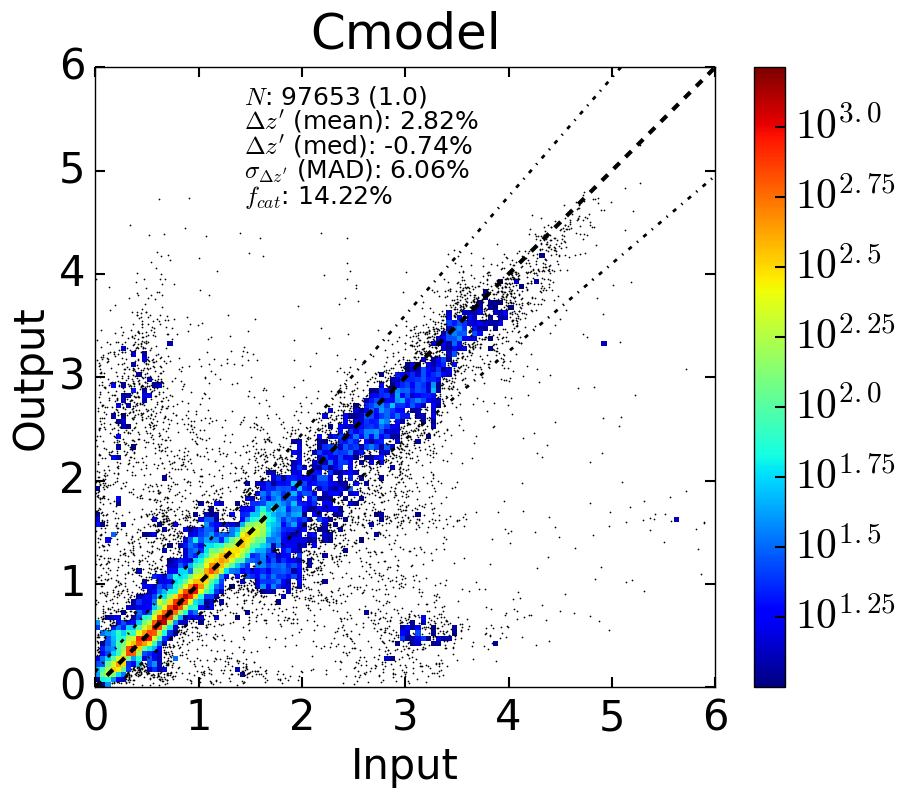

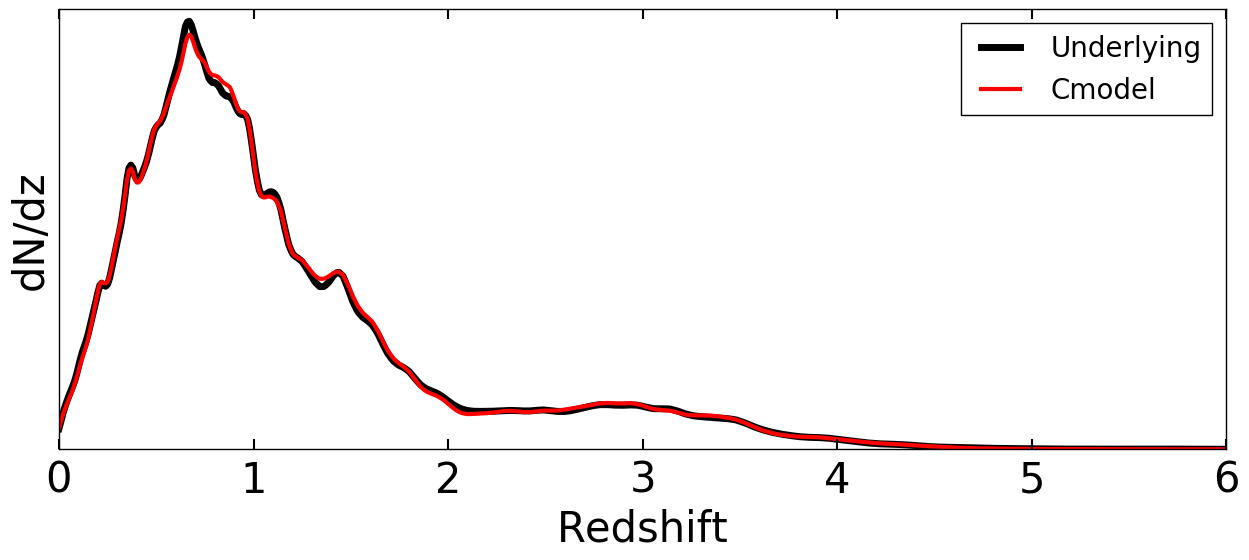

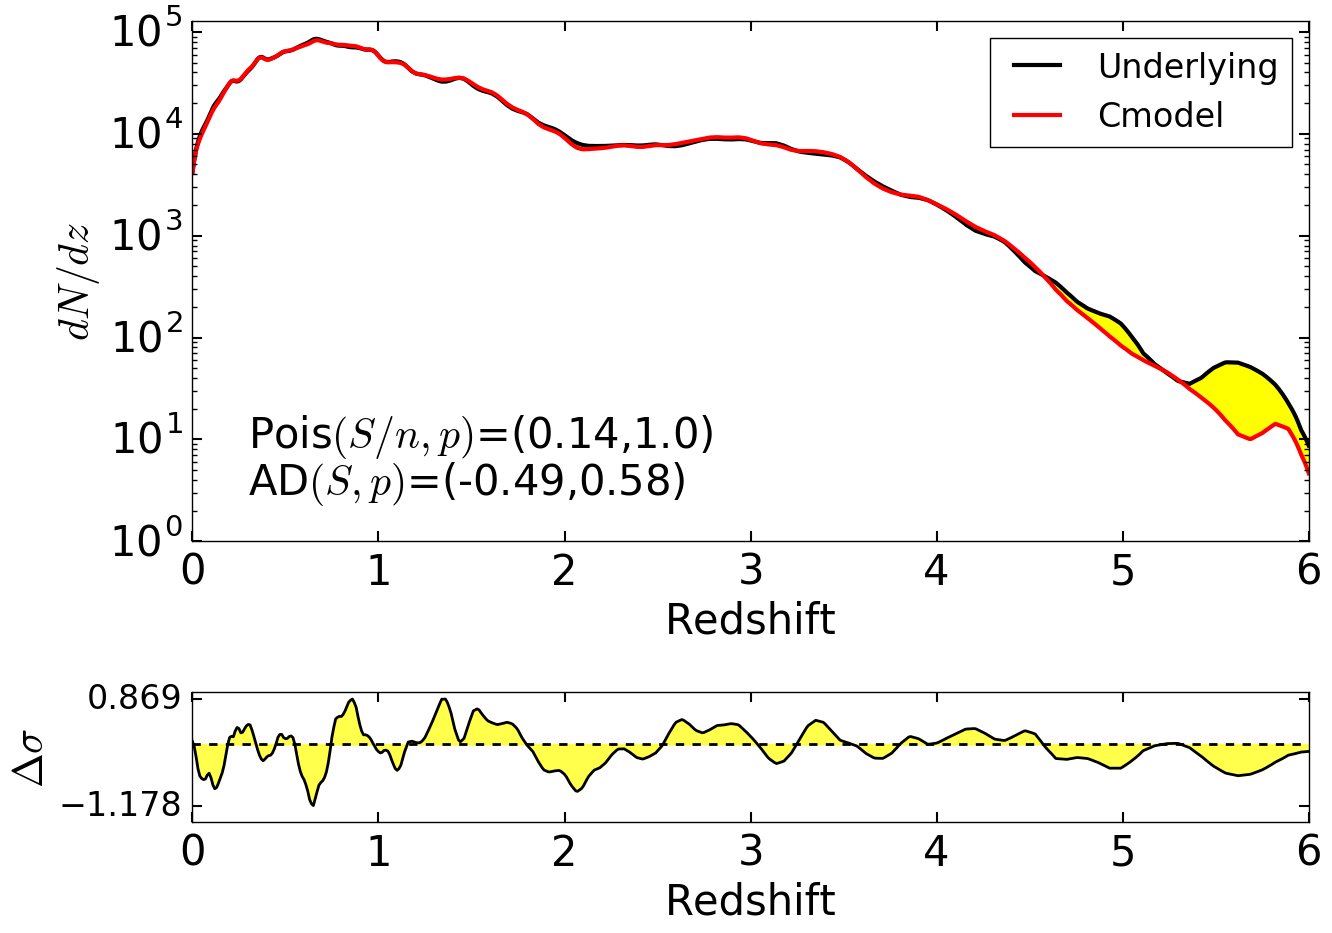

In [20]:
# plotting results
figure(figsize=(10,8))
fz.plot_zpoints('Cmodel',z[test_sel],zpoints[1],weights=cv_weights[test_sel])

figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test,lzeidx_test,cv_weights[test_sel],
                      rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

nz_stack=nansum(zpdf*cv_weights[test_sel][:,None],axis=0)/cv_weights[test_sel].sum()
plot(rdict.zgrid_out,nz_stack,lw=3,color='red',label='Cmodel')
xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
yticks([])
ylabel('dN/dz')

figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*cv_weights[test_sel].sum(),nz_stack*cv_weights[test_sel].sum(),rdict.zgrid_out,rdict.dz_out,
                       sample_names=['Underlying','Cmodel'],colors=['black','red'])

See previous notebooks and function descriptions for more information on the diagnostics used in these plots. The one I'll be focusing most heavily on will be the redshift-normalized 1-$\sigma$ median scatter $\sigma_{\Delta z^\prime}(\textrm{MAD})$ computed from median point estimates $z_50$, which gives a robust probe of the general photo-z accuracy we can expect from the PDF.

### PSF Fluxes

In [21]:
p1,v1,m1=flux_psf[train_sel],square(err_psf[train_sel]),mask_psf[train_sel]
p2,v2,m2=flux_psf[test_sel],square(err_psf_wide[test_sel]),mask_psf[test_sel]
e1,e2=sqrt(v1+square(0.01*p1)),sqrt(v2+square(0.01*p2)) # add 1% error floor

mag1,mage1=fz.asinh_mag_map(p1,e1,zeropoint=flux_zeropoint,skynoise=skynoise) # Luptitude mapping
mag2,mage2=fz.asinh_mag_map(p2,e2,zeropoint=flux_zeropoint,skynoise=skynoise) # Luptitude mapping

# initialize WINBET instances
winbet_train,winbet_test=fz.WINBET(Ntrees=25),fz.WINBET(Ntrees=25) # intialize WINBET

if (m1==False).sum()>0:
    winbet_train.train(p1,v1,m1,mag1,mage1,mdict)
else:
    winbet_train=None
    
if (m2==False).sum()>0:
    winbet_test.train(p2,v2,m2,mag2,mage2,mdict)
else:
    winbet_test=None

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

In [22]:
frankenz=fz.FRANKENZ(N_members=25)
model_obj,model_Nobj,model_ll,model_Nbands=frankenz.predict(p1,e1,m1,p2,e2,m2,
                                                            impute_train=winbet_train,impute_test=winbet_test)

0 0 0 1 0 0 2 0 0 3 0 0 4 0 0 5 0 0 6 0 0 7 0 0 8 0 0 9 0 0 10 0 0 11 0 0 12 0 0 13 0 0 14 0 0 15 0 0 16 0 0 17 0 0 18 0 0 19 0 0 20 0 0 21 0 0 22 0 0 23 0 0 24 0 0 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!


In [23]:
# generate redshifts
model_llmin=empty(Ntest).astype(float)
lzpdf=empty((Ntest,rdict.Nz))
zpdf=empty((Ntest,rdict.Nz_out))
model_levidence=empty(Ntest)

for i in xrange(Ntest):
    if i%1000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    model_llmin[i]=ll.min() # minimum value (for scaling)
    w=exp(-0.5*(ll-model_llmin[i])) # transform to scaled likelihood weights
    model_levidence[i]=-2*log(w.sum())+model_llmin[i] # -2ln(Evidence)
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train[midx],lzeidx_train[midx],w,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[i]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# normalize PDFs   
zpdf=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out)

# compute point estimates
zpoints=fz.pdfs_summary_statistics(rdict.zgrid_out,zpdf) # mean, med, mode, l68, h68, l95, h95, std, conf

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 Resampling PDFs...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!
Computing PDF quantities...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!


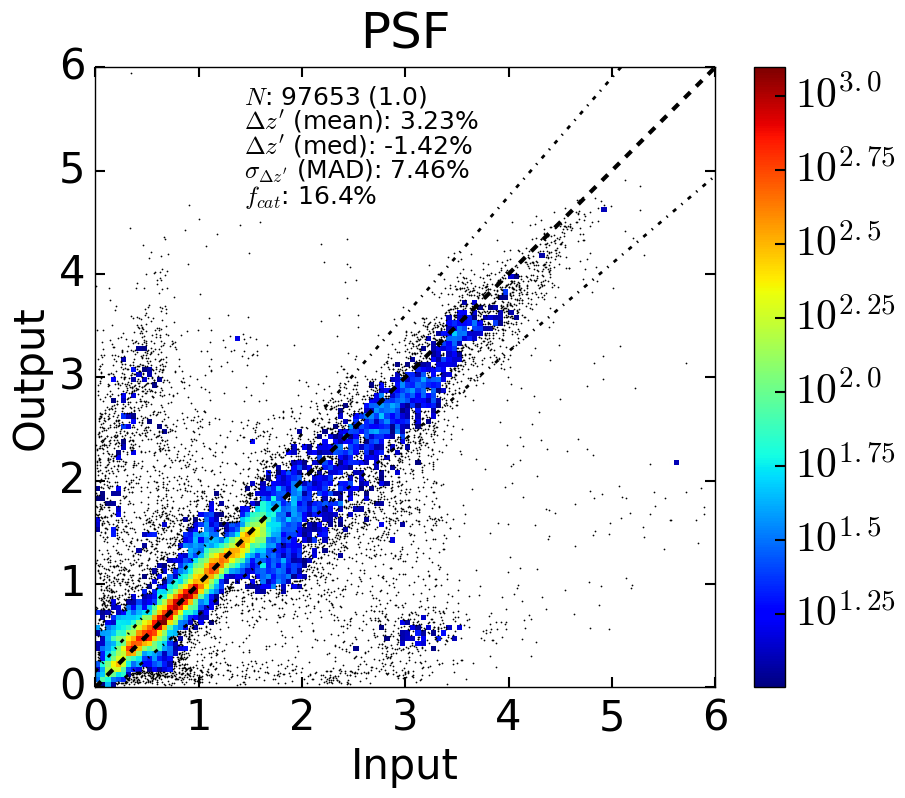

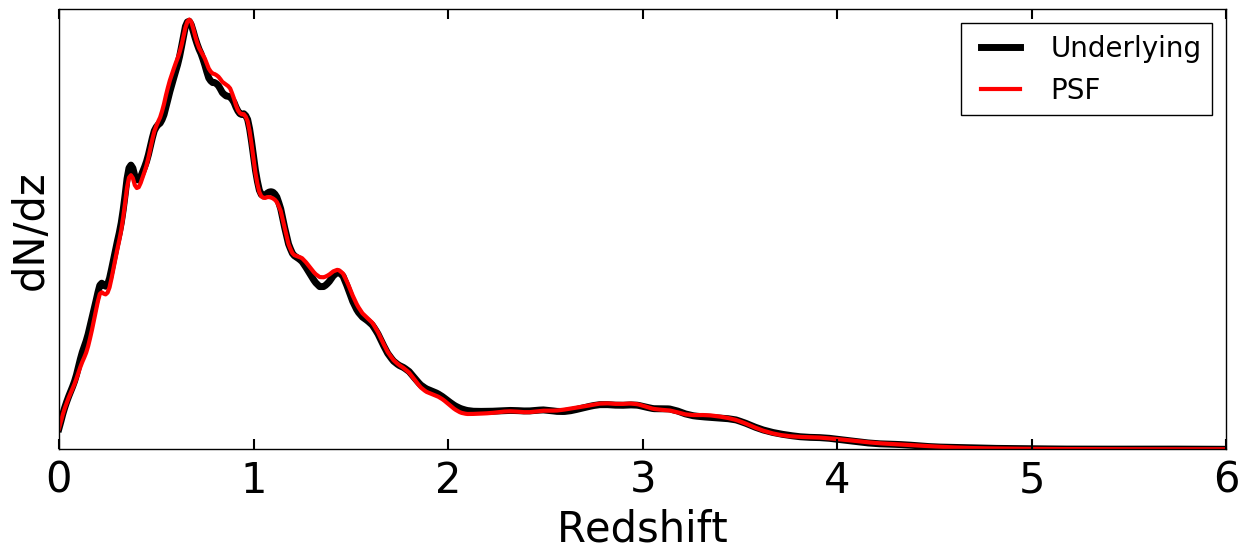

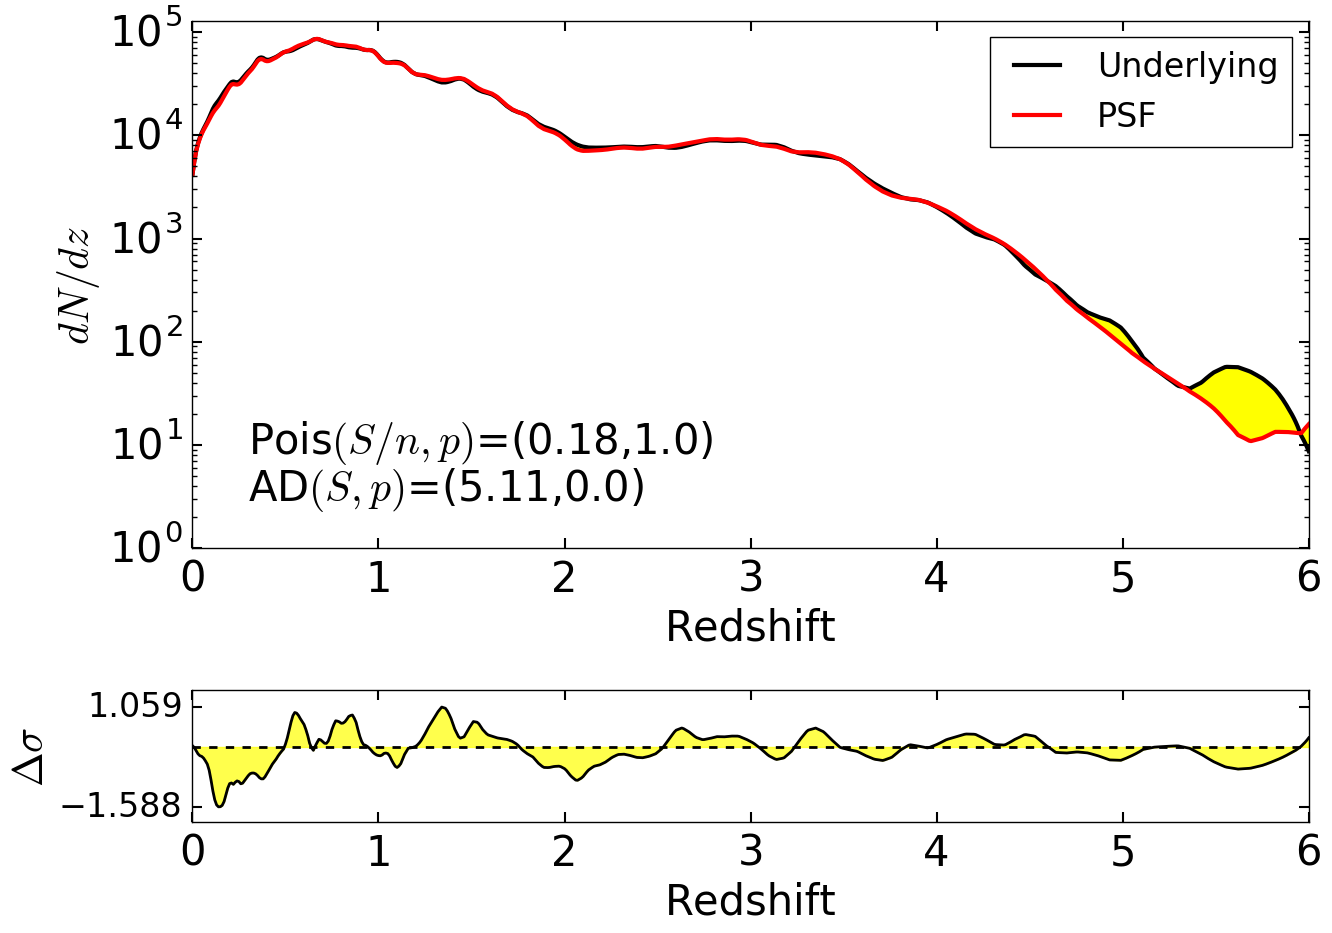

In [24]:
# plotting results
figure(figsize=(10,8))
fz.plot_zpoints('PSF',z[test_sel],zpoints[1],weights=cv_weights[test_sel])

figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test,lzeidx_test,cv_weights[test_sel],
                      rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

nz_stack=nansum(zpdf*cv_weights[test_sel][:,None],axis=0)/cv_weights[test_sel].sum()
plot(rdict.zgrid_out,nz_stack,lw=3,color='red',label='PSF')
xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
yticks([])
ylabel('dN/dz')

figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*cv_weights[test_sel].sum(),nz_stack*cv_weights[test_sel].sum(),rdict.zgrid_out,rdict.dz_out,
                       sample_names=['Underlying','PSF'],colors=['black','red'])

### Cmodel Dev+Exp Fluxes

We now broaden our feature space to include each of the fitted components of the cmodel flux.

In [32]:
temp1=c_[flux_cmodel_dev,flux_cmodel_exp]
temp2=c_[err_cmodel_dev,err_cmodel_exp]
temp2_wide=c_[err_cmodel_dev_wide,err_cmodel_exp_wide]
tempm=c_[mask_cmodel_dev,mask_cmodel_exp]

p1,v1,m1=temp1[train_sel],square(temp2[train_sel]),tempm[train_sel]
p2,v2,m2=temp1[test_sel],square(temp2_wide[test_sel]),tempm[test_sel]
e1,e2=sqrt(v1+square(0.01*p1)),sqrt(v2+square(0.01*p2)) # add 1% error floor

frankenz=fz.FRANKENZ(N_members=25)
model_obj,model_Nobj,model_ll,model_Nbands=frankenz.predict(p1,e1,m1,p2,e2,m2)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!


In [33]:
# generate redshifts
model_llmin=empty(Ntest).astype(float)
lzpdf=empty((Ntest,rdict.Nz))
zpdf=empty((Ntest,rdict.Nz_out))
model_levidence=empty(Ntest)

for i in xrange(Ntest):
    if i%1000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    model_llmin[i]=ll.min() # minimum value (for scaling)
    w=exp(-0.5*(ll-model_llmin[i])) # transform to scaled likelihood weights
    model_levidence[i]=-2*log(w.sum())+model_llmin[i] # -2ln(Evidence)
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train[midx],lzeidx_train[midx],w,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[i]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# normalize PDFs   
zpdf=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out)

# compute point estimates
zpoints=fz.pdfs_summary_statistics(rdict.zgrid_out,zpdf) # mean, med, mode, l68, h68, l95, h95, std, conf

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 Resampling PDFs...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!
Computing PDF quantities...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!


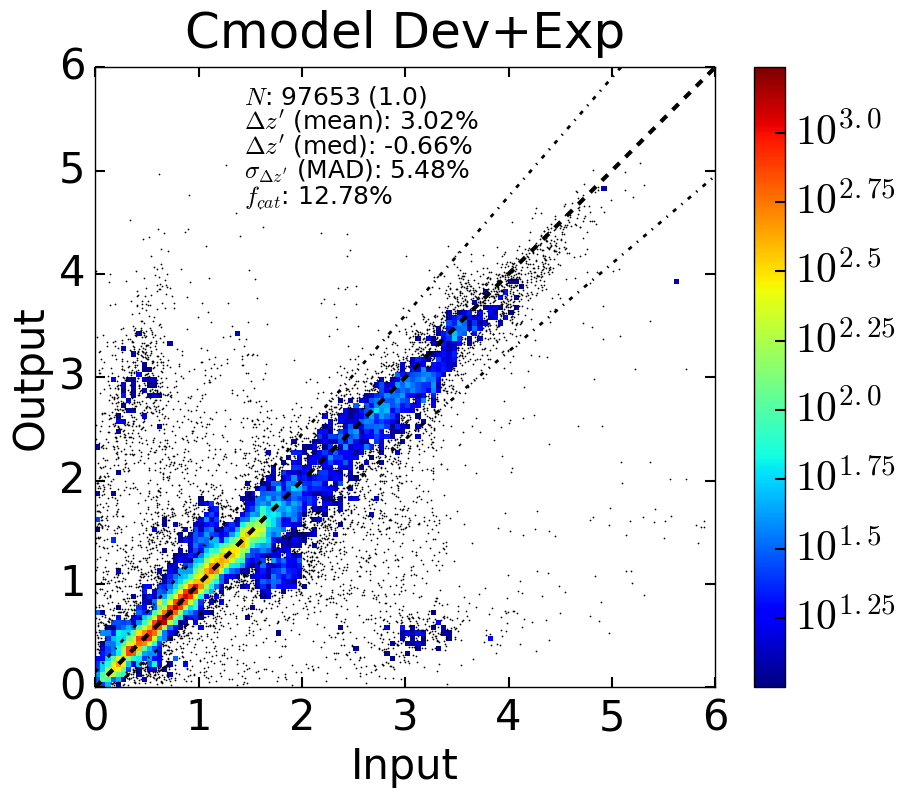

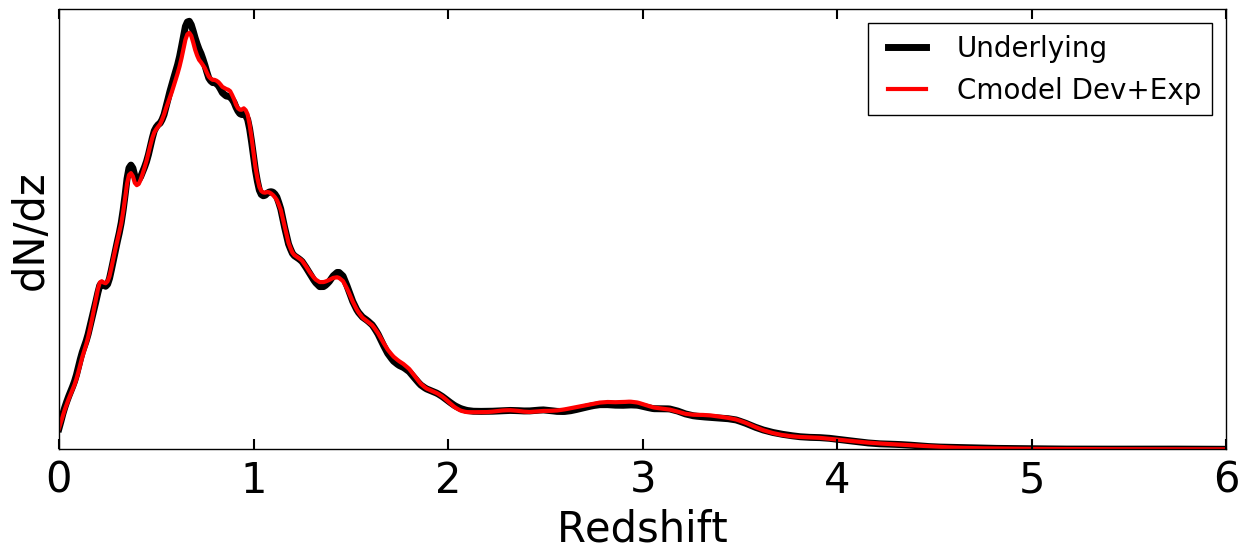

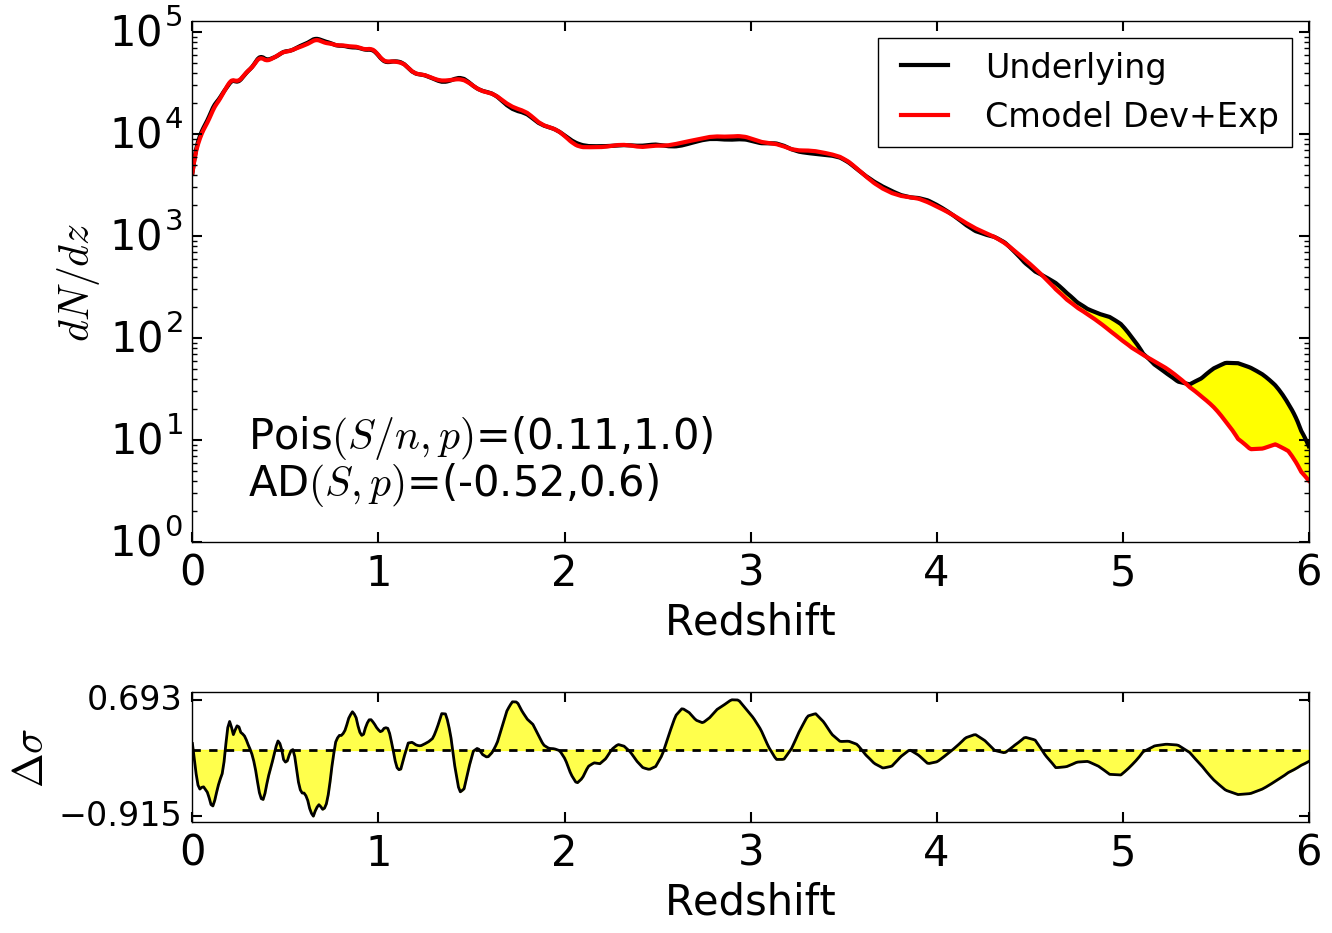

In [34]:
# plotting results
figure(figsize=(10,8))
fz.plot_zpoints('Cmodel Dev+Exp',z[test_sel],zpoints[1],weights=cv_weights[test_sel])

figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test,lzeidx_test,cv_weights[test_sel],
                      rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

nz_stack=nansum(zpdf*cv_weights[test_sel][:,None],axis=0)/cv_weights[test_sel].sum()
plot(rdict.zgrid_out,nz_stack,lw=3,color='red',label='Cmodel Dev+Exp')
xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
yticks([])
ylabel('dN/dz')

figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*cv_weights[test_sel].sum(),nz_stack*cv_weights[test_sel].sum(),rdict.zgrid_out,rdict.dz_out,
                       sample_names=['Underlying','Cmodel Dev+Exp'],colors=['black','red'])

### Afterburner Fluxes

PSF-matched aperture fluxes were computed during the "afterburner" run, hence the name.

In [35]:
p1,v1,m1=flux_afterburner[train_sel],square(err_afterburner[train_sel]),mask_afterburner[train_sel]
p2,v2,m2=flux_afterburner[test_sel],square(err_cmodel_wide[test_sel]),mask_afterburner[test_sel]
e1,e2=sqrt(v1+square(0.01*p1)),sqrt(v2+square(0.01*p2)) # add 1% error floor

mag1,mage1=fz.asinh_mag_map(p1,e1,zeropoint=flux_zeropoint,skynoise=skynoise) # Luptitude mapping
mag2,mage2=fz.asinh_mag_map(p2,e2,zeropoint=flux_zeropoint,skynoise=skynoise) # Luptitude mapping

# initialize WINBET instances
winbet_train,winbet_test=fz.WINBET(Ntrees=25),fz.WINBET(Ntrees=25)

if (m1==False).sum()>0:
    winbet_train.train(p1,v1,m1,mag1,mage1,mdict)
else:
    winbet_train=None
    
if (m2==False).sum()>0:
    winbet_test.train(p2,v2,m2,mag2,mage2,mdict)
else:
    winbet_test=None

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

In [36]:
frankenz=fz.FRANKENZ(N_members=25)
model_obj,model_Nobj,model_ll,model_Nbands=frankenz.predict(p1,e1,m1,p2,e2,m2,
                                                           impute_train=winbet_train,impute_test=winbet_test)

0 0 0 1 0 0 2 0 0 3 0 0 4 0 0 5 0 0 6 0 0 7 0 0 8 0 0 9 0 0 10 0 0 11 0 0 12 0 0 13 0 0 14 0 0 15 0 0 16 0 0 17 0 0 18 0 0 19 0 0 20 0 0 21 0 0 22 0 0 23 0 0 24 0 0 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!


In [37]:
# generate redshifts
model_llmin=empty(Ntest).astype(float)
lzpdf=empty((Ntest,rdict.Nz))
zpdf=empty((Ntest,rdict.Nz_out))
model_levidence=empty(Ntest)

for i in xrange(Ntest):
    if i%1000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    model_llmin[i]=ll.min() # minimum value (for scaling)
    w=exp(-0.5*(ll-model_llmin[i])) # transform to scaled likelihood weights
    model_levidence[i]=-2*log(w.sum())+model_llmin[i] # -2ln(Evidence)
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train[midx],lzeidx_train[midx],w,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[i]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# normalize PDFs
zpdf=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out)

# compute point estimates
zpoints=fz.pdfs_summary_statistics(rdict.zgrid_out,zpdf) # mean, med, mode, l68, h68, l95, h95, std, conf

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 Resampling PDFs...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!
Computing PDF quantities...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!


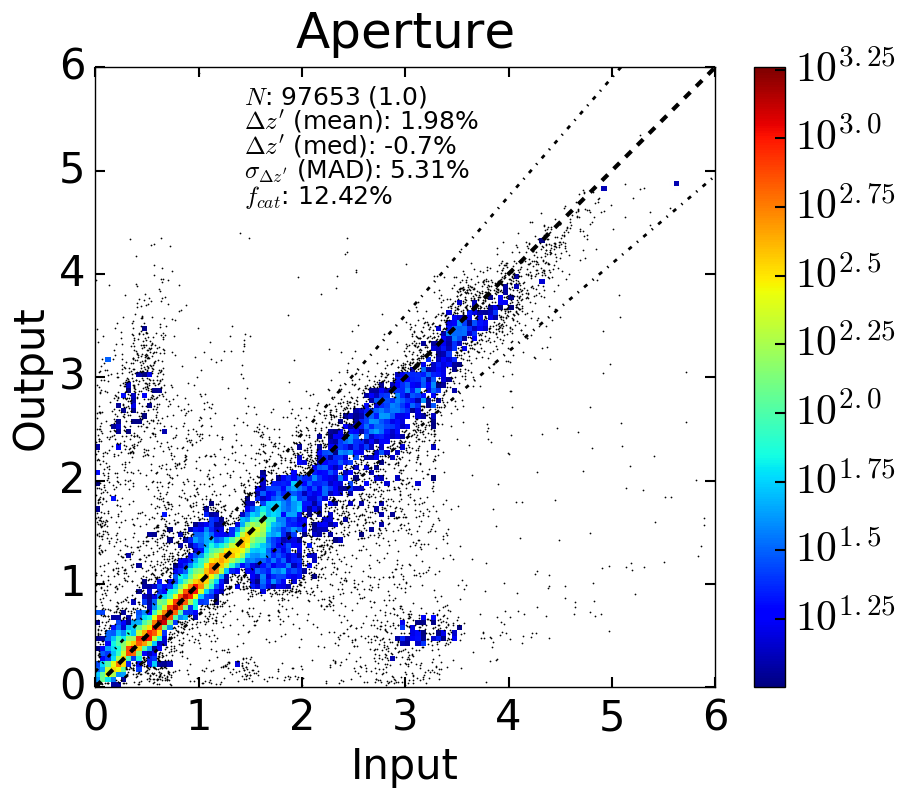

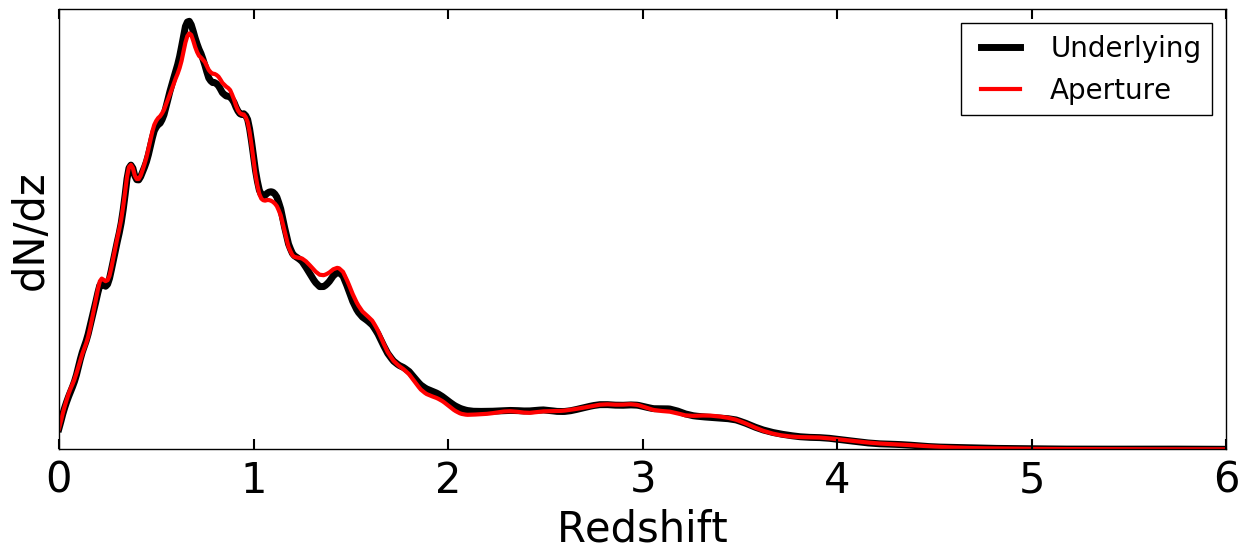

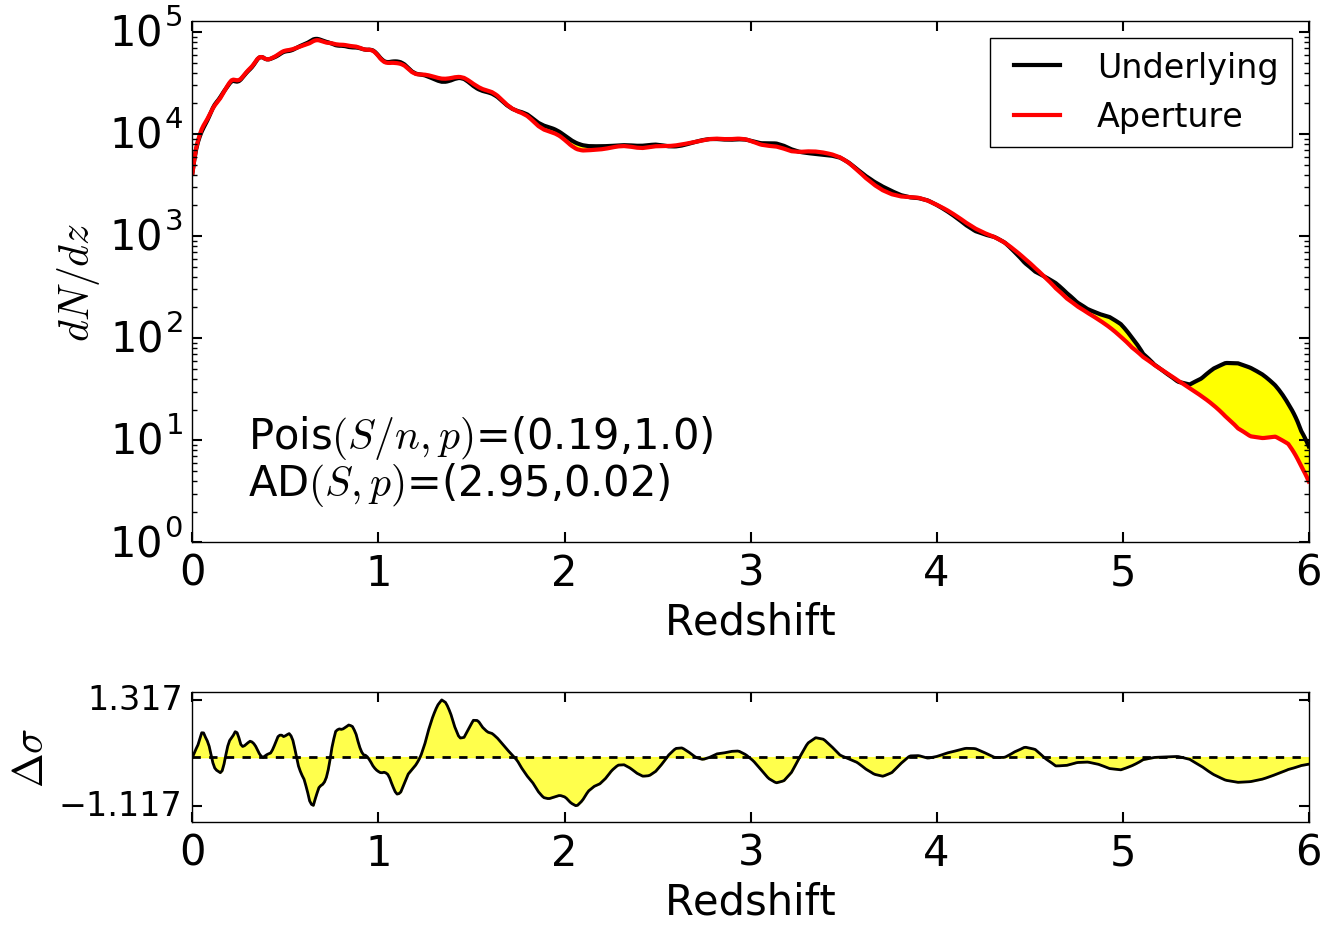

In [38]:
# plotting results
figure(figsize=(10,8))
fz.plot_zpoints('Aperture',z[test_sel],zpoints[1],weights=cv_weights[test_sel])

figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test,lzeidx_test,cv_weights[test_sel],
                      rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

nz_stack=nansum(zpdf*cv_weights[test_sel][:,None],axis=0)/cv_weights[test_sel].sum()
plot(rdict.zgrid_out,nz_stack,lw=3,color='red',label='Aperture')
xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
yticks([])
ylabel('dN/dz')

figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*cv_weights[test_sel].sum(),nz_stack*cv_weights[test_sel].sum(),rdict.zgrid_out,rdict.dz_out,
                       sample_names=['Underlying','Aperture'],colors=['black','red'])

# Follow-Up Tests

Performance seems to go (in order): 

1. afterburner (psf-matched aperture) flux
2. cmodel dev+exp flux
3. cmodel flux
4. psf flux

Now let's add together a couple of different fluxes to try and see where performance stops improving (especially since the scaling with dimensionality isn't great and we're forced to subsample features).

### Aper+Cmodel(i)

In [29]:
temp1=c_[flux_afterburner,flux_cmodel[:,2]]
temp2=c_[err_afterburner,err_cmodel[:,2]]
temp2_wide=c_[err_cmodel_wide,err_cmodel_wide[:,2]]
tempm=c_[mask_afterburner,mask_cmodel[:,2]]
snoise=append(skynoise,skynoise[2])

p1,v1,m1=temp1[train_sel],square(temp2[train_sel]),tempm[train_sel]
p2,v2,m2=temp1[test_sel],square(temp2_wide[test_sel]),tempm[test_sel]
e1,e2=sqrt(v1+square(0.01*p1)),sqrt(v2+square(0.01*p2)) # add 1% error floor

mag1,mage1=fz.asinh_mag_map(p1,e1,zeropoint=flux_zeropoint,skynoise=snoise) # Luptitude mapping
mag2,mage2=fz.asinh_mag_map(p2,e2,zeropoint=flux_zeropoint,skynoise=snoise) # Luptitude mapping

# initialize WINBET instances
winbet_train,winbet_test=fz.WINBET(Ntrees=25),fz.WINBET(Ntrees=25)

if (m1==False).sum()>0:
    winbet_train.train(p1,v1,m1,mag1,mage1,mdict)
else:
    winbet_train=None
    
if (m2==False).sum()>0:
    winbet_test.train(p2,v2,m2,mag2,mage2,mdict)
else:
    winbet_test=None

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

In [30]:
frankenz=fz.FRANKENZ(N_members=25) # default values: N_MC=100, N_neighbors=10
model_obj,model_Nobj,model_ll,model_Nbands=frankenz.predict(p1,e1,m1,p2,e2,m2,
                                                           impute_train=winbet_train,impute_test=winbet_test)

0 0 0 1 0 0 2 0 0 3 0 0 4 0 0 5 0 0 6 0 0 7 0 0 8 0 0 9 0 0 10 0 0 11 0 0 12 0 0 13 0 0 14 0 0 15 0 0 16 0 0 17 0 0 18 0 0 19 0 0 20 0 0 21 0 0 22 0 0 23 0 0 24 0 0 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!


In [31]:
# generate redshifts
model_llmin=empty(Ntest).astype(float)
lzpdf=empty((Ntest,rdict.Nz))
zpdf=empty((Ntest,rdict.Nz_out))
model_levidence=empty(Ntest)

for i in xrange(Ntest):
    if i%1000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    model_llmin[i]=ll.min() # minimum value (for scaling)
    w=exp(-0.5*(ll-model_llmin[i])) # transform to scaled likelihood weights
    model_levidence[i]=-2*log(w.sum())+model_llmin[i] # -2ln(Evidence)
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train[midx],lzeidx_train[midx],w,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[i]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# normalize PDFs
zpdf=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out)

# compute point estimates
zpoints=fz.pdfs_summary_statistics(rdict.zgrid_out,zpdf) # mean, med, mode, l68, h68, l95, h95, std, conf

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 Resampling PDFs...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!
Computing PDF quantities...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!


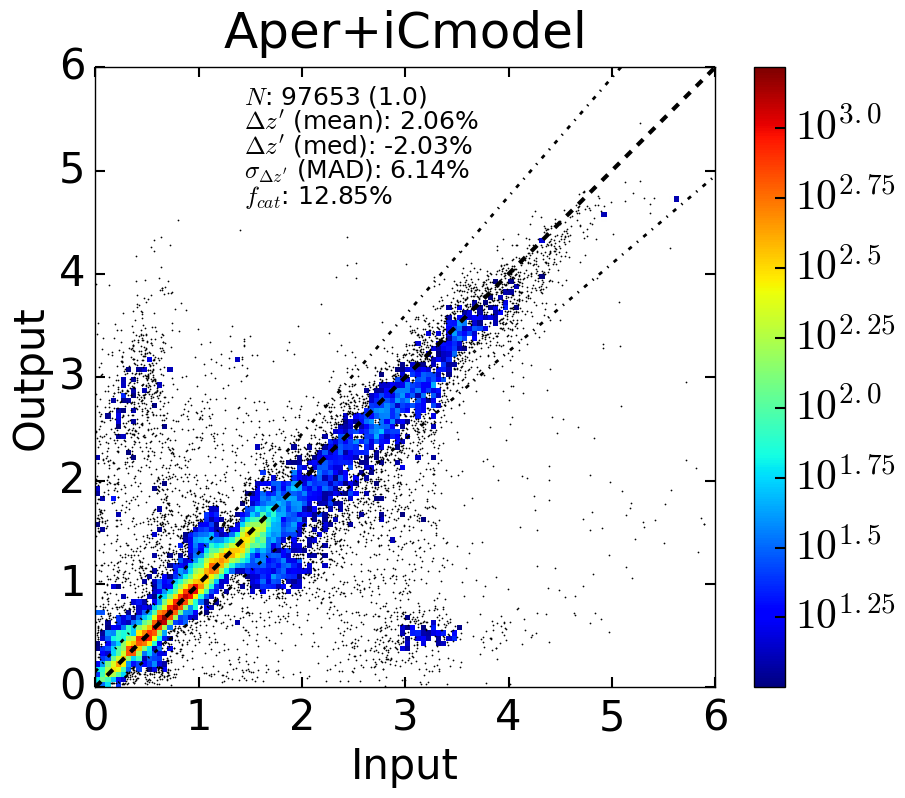

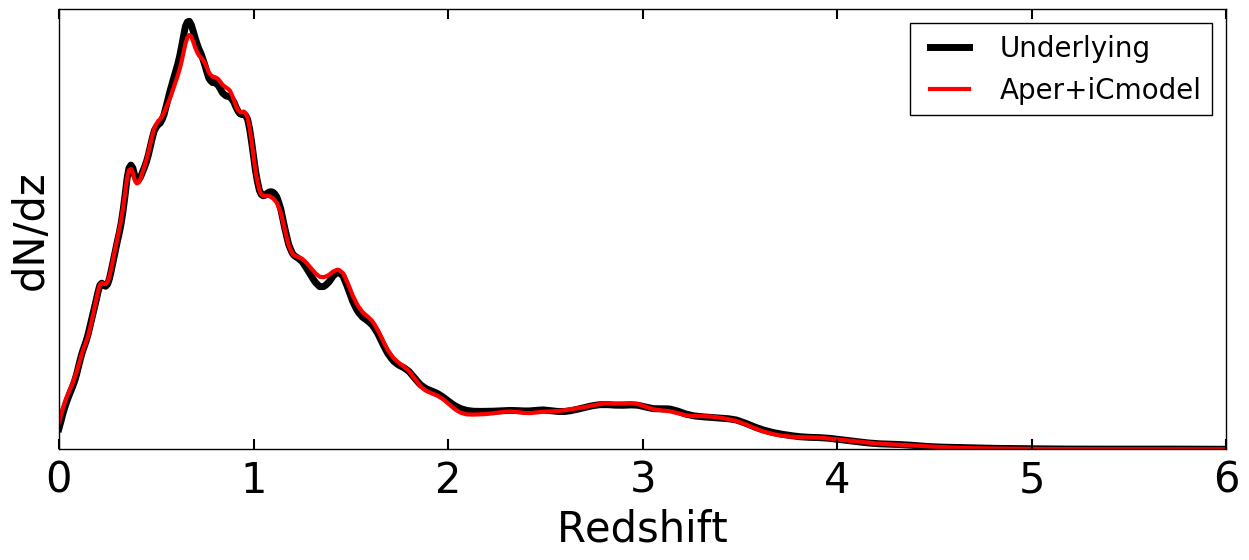

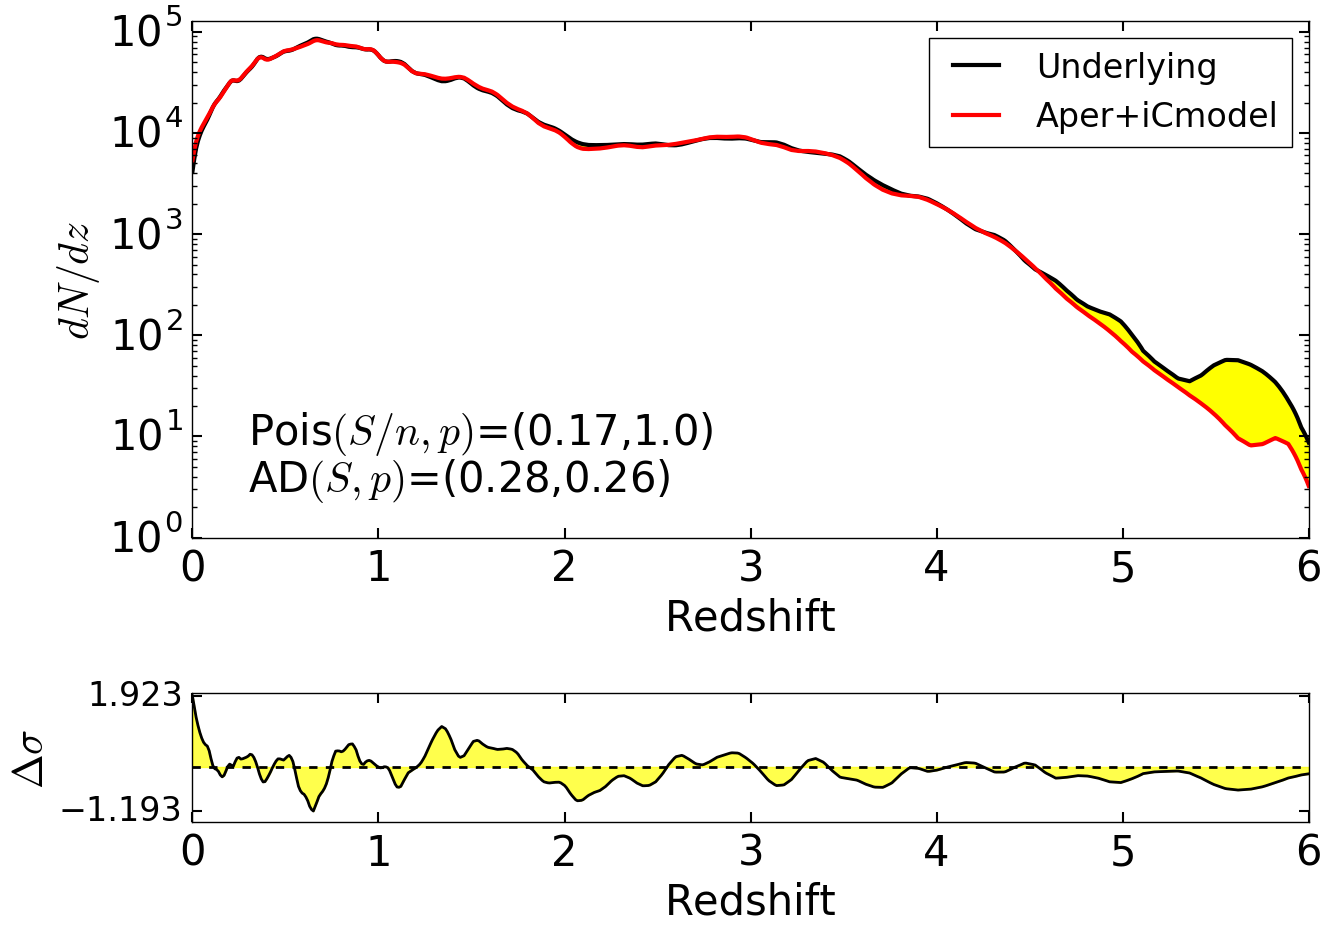

In [33]:
# plotting results
figure(figsize=(10,8))
fz.plot_zpoints('Aper+iCmodel',z[test_sel],zpoints[1],weights=cv_weights[test_sel])

figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test,lzeidx_test,cv_weights[test_sel],
                      rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

nz_stack=nansum(zpdf*cv_weights[test_sel][:,None],axis=0)/cv_weights[test_sel].sum()
plot(rdict.zgrid_out,nz_stack,lw=3,color='red',label='Aper+iCmodel')
xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
yticks([])
ylabel('dN/dz')

figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*cv_weights[test_sel].sum(),nz_stack*cv_weights[test_sel].sum(),rdict.zgrid_out,rdict.dz_out,
                       sample_names=['Underlying','Aper+iCmodel'],colors=['black','red'])

### Aper+Cmodel

In [19]:
temp1=c_[flux_afterburner,flux_cmodel]
temp2=c_[err_afterburner,err_cmodel]
temp2_wide=c_[err_cmodel_wide,err_cmodel_wide]
tempm=c_[mask_afterburner,mask_cmodel]
snoise=array([skynoise for i in xrange(2)]).flatten()

p1,v1,m1=temp1[train_sel],square(temp2[train_sel]),tempm[train_sel]
p2,v2,m2=temp1[test_sel],square(temp2_wide[test_sel]),tempm[test_sel]
e1,e2=sqrt(v1+square(0.01*p1)),sqrt(v2+square(0.01*p2)) # add 1% error floor

mag1,mage1=fz.asinh_mag_map(p1,e1,zeropoint=flux_zeropoint,skynoise=snoise) # Luptitude mapping
mag2,mage2=fz.asinh_mag_map(p2,e2,zeropoint=flux_zeropoint,skynoise=snoise) # Luptitude mapping

# initialize WINBET instances
winbet_train,winbet_test=fz.WINBET(Ntrees=25),fz.WINBET(Ntrees=25)

if (m1==False).sum()>0:
    winbet_train.train(p1,v1,m1,mag1,mage1,mdict)
else:
    winbet_train=None
    
if (m2==False).sum()>0:
    winbet_test.train(p2,v2,m2,mag2,mage2,mdict)
else:
    winbet_test=None

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

Training/Searching a k-d tree in higher dimensions starts to get prohibitively slow. Therefore we now want to **subsample** our expanded set of features when looking for neighbors. We have two options for this, both of which are implemented in FRANKEN-Z:
1. **Random subsample**. This is commonly used in ensemble methods (e.g., random forests) to reduce overfitting. This means we'd just pick some of the fluxes at random during each iteration and search that reduced parameter space.
2. **Pre-defined subsample**. In this case, we define a specific set of features that we always search. Equivalently, we always search a given subspace/projection of the data rather than a random projection.

Since the afterburner fluxes seem to be a good projection surface, we'll choose that as our default going forward.

In [20]:
frankenz=fz.FRANKENZ(N_members=25) # default values: N_MC=100, N_neighbors=10
model_obj,model_Nobj,model_ll,model_Nbands=frankenz.predict(p1,e1,m1,p2,e2,m2,subsample=arange(5),
                                                           impute_train=winbet_train,impute_test=winbet_test)

0 0 0 1 0 0 2 0 0 3 0 0 4 0 0 5 0 0 6 0 0 7 0 0 8 0 0 9 0 0 10 0 0 11 0 0 12 0 0 13 0 0 14 0 0 15 0 0 16 0 0 17 0 0 18 0 0 19 0 0 20 0 0 21 0 0 22 0 0 23 0 0 24 0 0 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!


In [21]:
# generate redshifts
model_llmin=empty(Ntest).astype(float)
lzpdf=empty((Ntest,rdict.Nz))
zpdf=empty((Ntest,rdict.Nz_out))
model_levidence=empty(Ntest)

for i in xrange(Ntest):
    if i%1000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    model_llmin[i]=ll.min() # minimum value (for scaling)
    w=exp(-0.5*(ll-model_llmin[i])) # transform to scaled likelihood weights
    model_levidence[i]=-2*log(w.sum())+model_llmin[i] # -2ln(Evidence)
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train[midx],lzeidx_train[midx],w,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[i]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# normalize PDFs
zpdf=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out)

# compute point estimates
zpoints=fz.pdfs_summary_statistics(rdict.zgrid_out,zpdf) # mean, med, mode, l68, h68, l95, h95, std, conf

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 Resampling PDFs...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!
Computing PDF quantities...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!


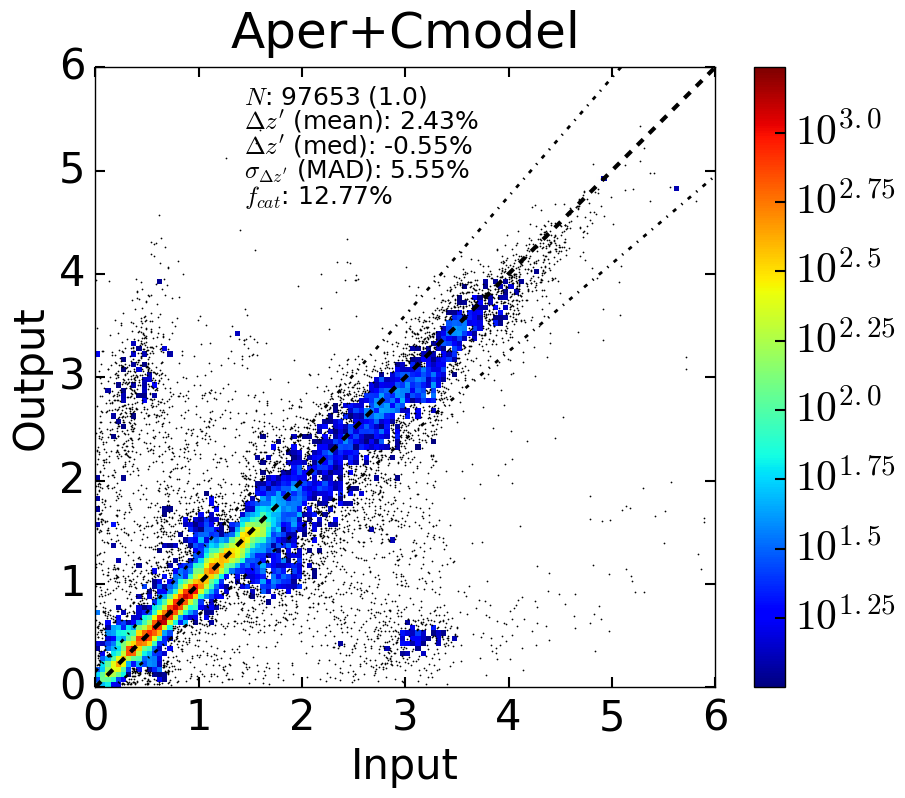

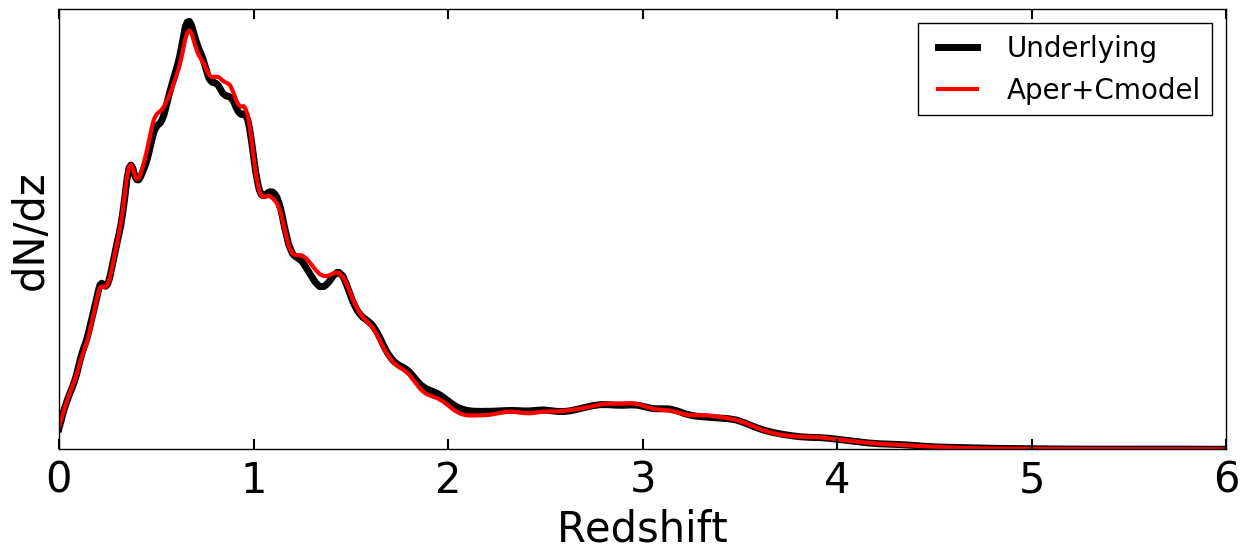

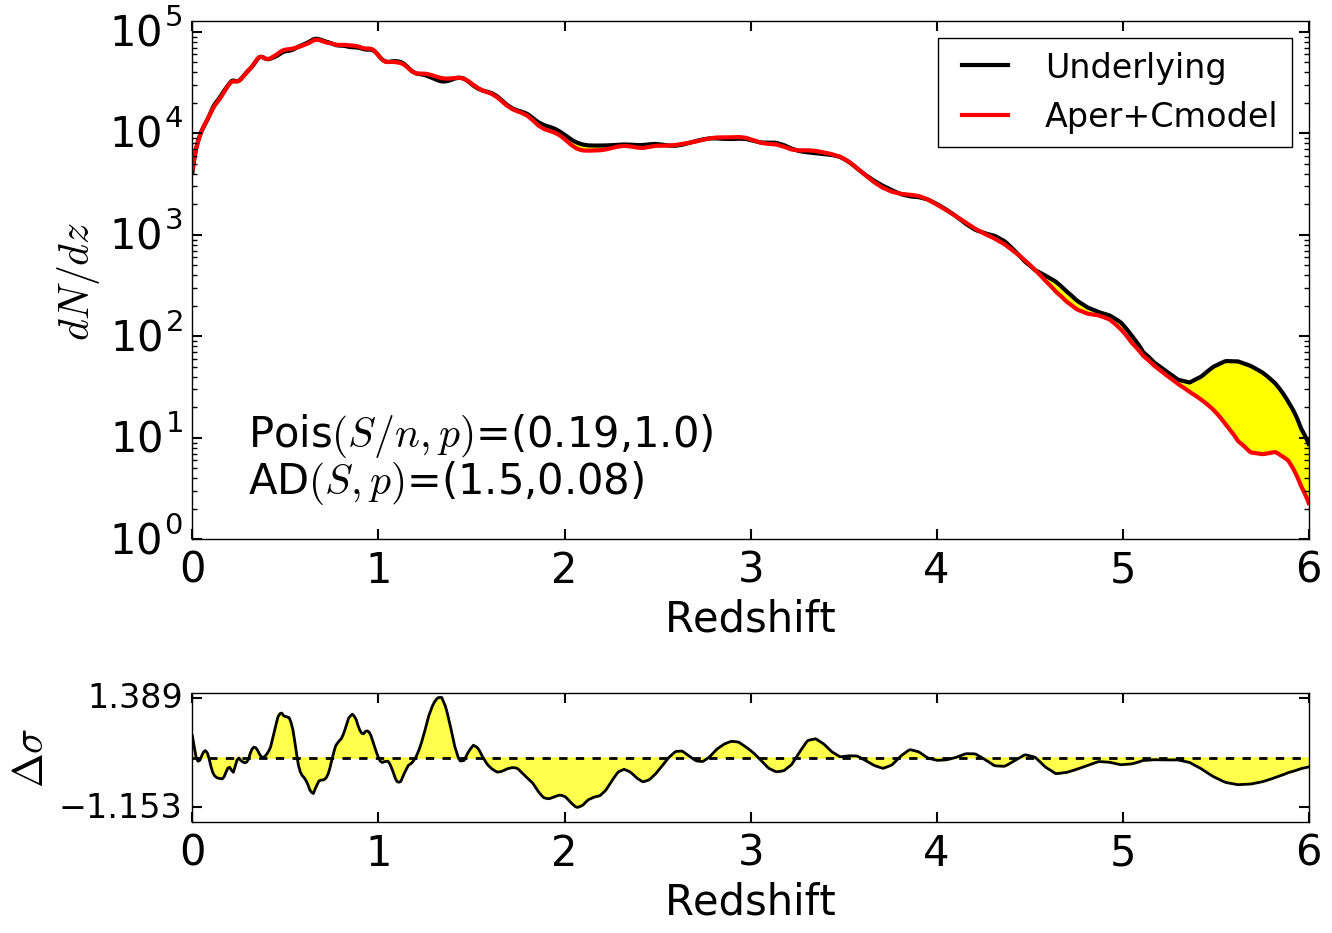

In [22]:
# plotting results
figure(figsize=(10,8))
fz.plot_zpoints('Aper+Cmodel',z[test_sel],zpoints[1],weights=cv_weights[test_sel])

figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test,lzeidx_test,cv_weights[test_sel],
                      rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

nz_stack=nansum(zpdf*cv_weights[test_sel][:,None],axis=0)/cv_weights[test_sel].sum()
plot(rdict.zgrid_out,nz_stack,lw=3,color='red',label='Aper+Cmodel')
xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
yticks([])
ylabel('dN/dz')

figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*cv_weights[test_sel].sum(),nz_stack*cv_weights[test_sel].sum(),rdict.zgrid_out,rdict.dz_out,
                       sample_names=['Underlying','Aper+Cmodel'],colors=['black','red'])

### Aper+Cdev+Cexp

In [23]:
temp1=c_[flux_afterburner,flux_cmodel_dev,flux_cmodel_exp]
temp2=c_[err_afterburner,err_cmodel_dev,err_cmodel_exp]
temp2_wide=c_[err_cmodel_wide,err_cmodel_dev_wide,err_cmodel_exp_wide]
temp3=c_[mask_afterburner,mask_cmodel_dev,mask_cmodel_exp]
snoise=array([skynoise for i in xrange(3)]).flatten()

p1,v1,m1=temp1[train_sel],square(temp2[train_sel]),temp3[train_sel]
p2,v2,m2=temp1[test_sel],square(temp2_wide[test_sel]),temp3[test_sel]
e1,e2=sqrt(v1+square(0.01*p1)),sqrt(v2+square(0.01*p2)) # add 1% error floor

mag1,mage1=fz.asinh_mag_map(p1,e1,zeropoint=flux_zeropoint,skynoise=snoise) # Luptitude mapping
mag2,mage2=fz.asinh_mag_map(p2,e2,zeropoint=flux_zeropoint,skynoise=snoise) # Luptitude mapping

# initialize WINBET instances
winbet_train,winbet_test=fz.WINBET(Ntrees=25),fz.WINBET(Ntrees=25) # intialize WINBET (Ntrees=100,Nleaf=10)

if (m1==False).sum()>0:
    winbet_train.train(p1,v1,m1,mag1,mage1,mdict)
else:
    winbet_train=None
    
if (m2==False).sum()>0:
    winbet_test.train(p2,v2,m2,mag2,mage2,mdict)
else:
    winbet_test=None

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

In [24]:
frankenz=fz.FRANKENZ(N_members=25) # default values: N_MC=100, N_neighbors=10
model_obj,model_Nobj,model_ll,model_Nbands=frankenz.predict(p1,e1,m1,p2,e2,m2,subsample=arange(5),
                                                           impute_train=winbet_train,impute_test=winbet_test)

0 0 0 1 0 0 2 0 0 3 0 0 4 0 0 5 0 0 6 0 0 7 0 0 8 0 0 9 0 0 10 0 0 11 0 0 12 0 0 13 0 0 14 0 0 15 0 0 16 0 0 17 0 0 18 0 0 19 0 0 20 0 0 21 0 0 22 0 0 23 0 0 24 0 0 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!


In [25]:
# generate redshifts
model_llmin=empty(Ntest).astype(float)
lzpdf=empty((Ntest,rdict.Nz))
zpdf=empty((Ntest,rdict.Nz_out))
model_levidence=empty(Ntest)

for i in xrange(Ntest):
    if i%1000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    model_llmin[i]=ll.min() # minimum value (for scaling)
    w=exp(-0.5*(ll-model_llmin[i])) # transform to scaled likelihood weights
    model_levidence[i]=-2*log(w.sum())+model_llmin[i] # -2ln(Evidence)
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train[midx],lzeidx_train[midx],w,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[i]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# normalize PDFs
zpdf=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out)

# compute point estimates
zpoints=fz.pdfs_summary_statistics(rdict.zgrid_out,zpdf) # mean, med, mode, l68, h68, l95, h95, std, conf

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 Resampling PDFs...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!
Computing PDF quantities...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!


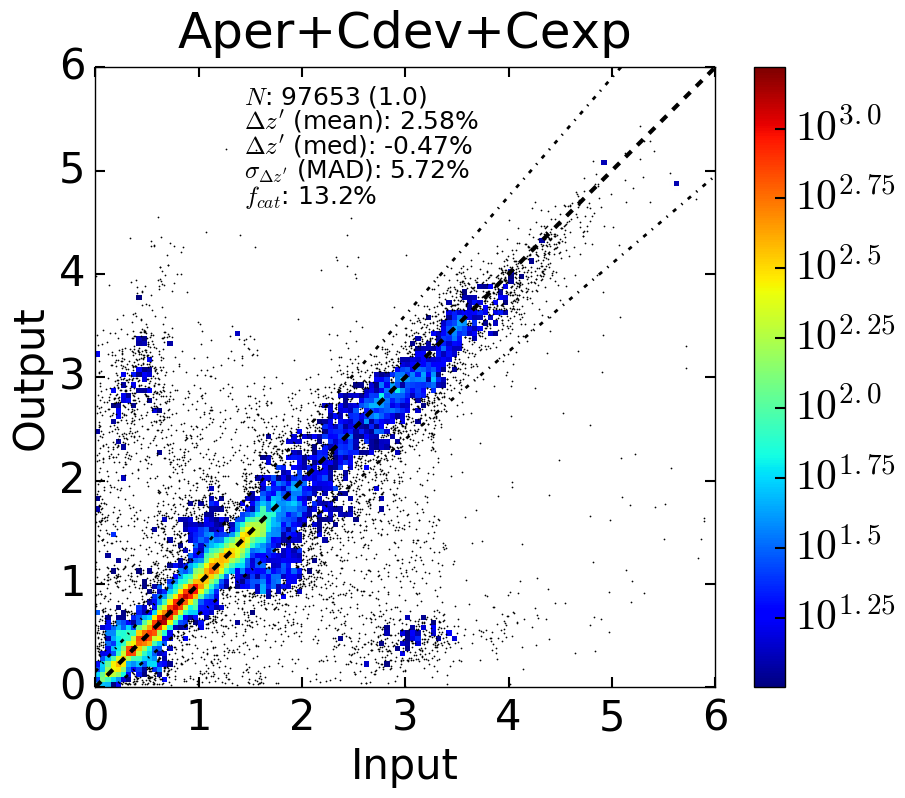

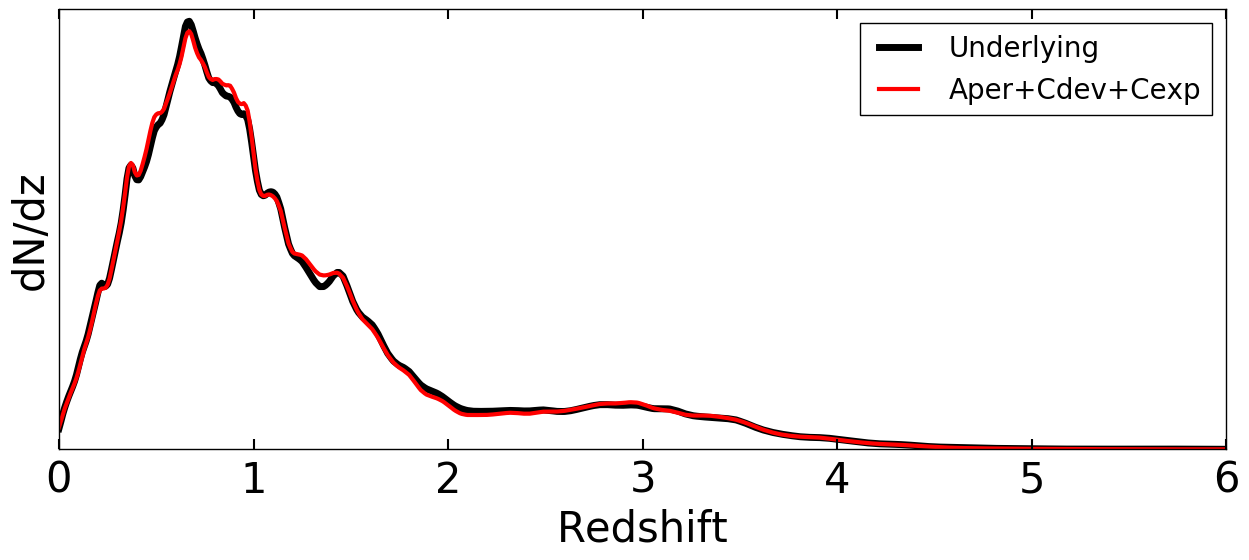

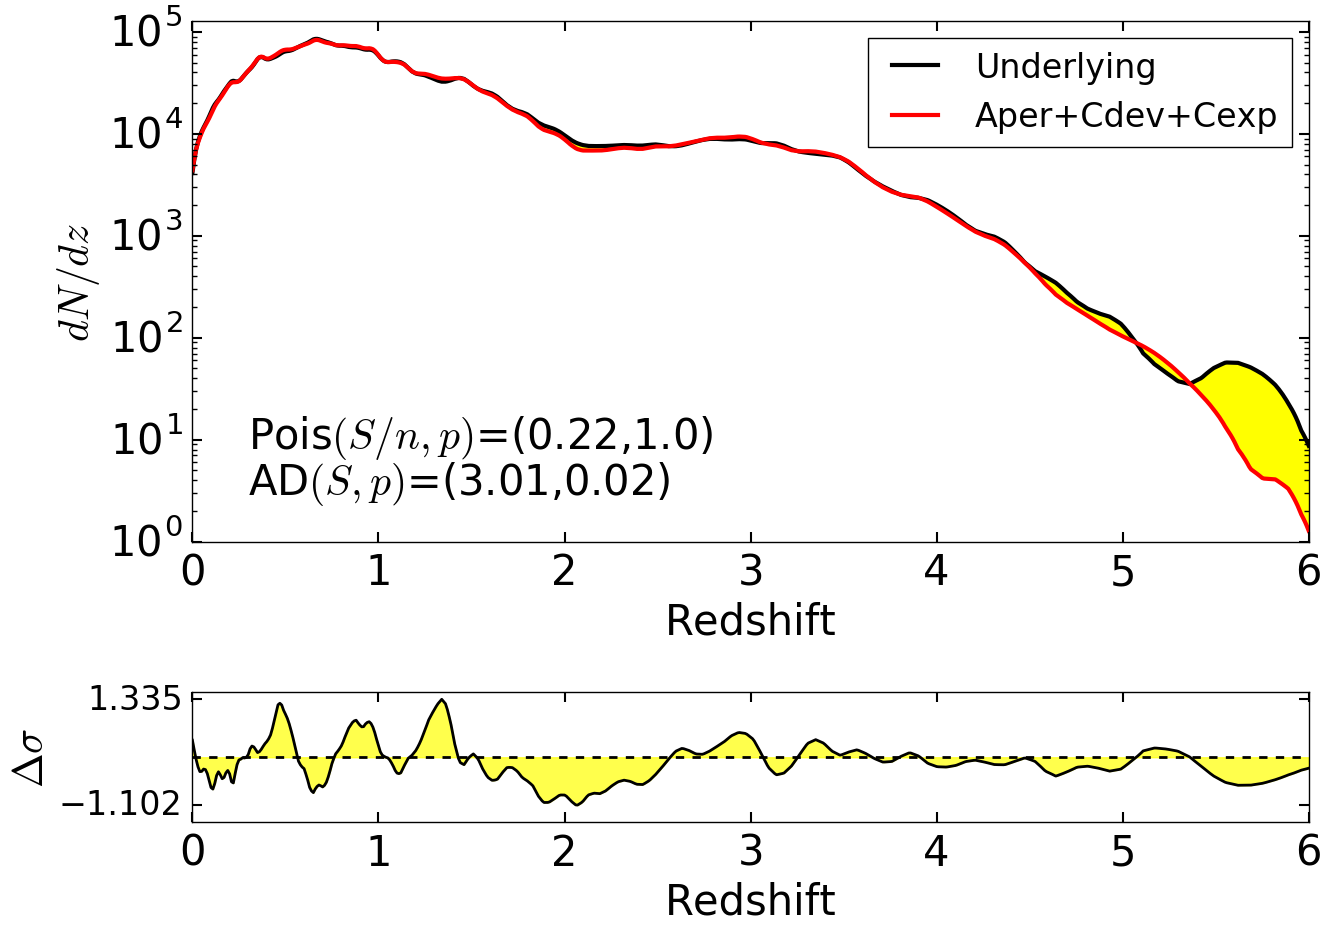

In [26]:
# plotting results
figure(figsize=(10,8))
fz.plot_zpoints('Aper+Cdev+Cexp',z[test_sel],zpoints[1],weights=cv_weights[test_sel])

figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test,lzeidx_test,cv_weights[test_sel],
                      rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

nz_stack=nansum(zpdf*cv_weights[test_sel][:,None],axis=0)/cv_weights[test_sel].sum()
plot(rdict.zgrid_out,nz_stack,lw=3,color='red',label='Aper+Cdev+Cexp')
xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
yticks([])
ylabel('dN/dz')

figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*cv_weights[test_sel].sum(),nz_stack*cv_weights[test_sel].sum(),rdict.zgrid_out,rdict.dz_out,
                       sample_names=['Underlying','Aper+Cdev+Cexp'],colors=['black','red'])

### Aper+PSF

In [27]:
temp1=c_[flux_afterburner,flux_psf]
temp2=c_[err_afterburner,err_psf]
temp2_wide=c_[err_cmodel_wide,err_psf_wide]
temp3=c_[mask_afterburner,mask_psf]
snoise=array([skynoise for i in xrange(2)]).flatten()

p1,v1,m1=temp1[train_sel],square(temp2[train_sel]),temp3[train_sel]
p2,v2,m2=temp1[test_sel],square(temp2_wide[test_sel]),temp3[test_sel]
e1,e2=sqrt(v1+square(0.01*p1)),sqrt(v2+square(0.01*p2)) # add 1% error floor

mag1,mage1=fz.asinh_mag_map(p1,e1,zeropoint=flux_zeropoint,skynoise=snoise) # Luptitude mapping
mag2,mage2=fz.asinh_mag_map(p2,e2,zeropoint=flux_zeropoint,skynoise=snoise) # Luptitude mapping

# initialize WINBET instances
winbet_train,winbet_test=fz.WINBET(Ntrees=25),fz.WINBET(Ntrees=25) # intialize WINBET (Ntrees=100,Nleaf=10)

if (m1==False).sum()>0:
    winbet_train.train(p1,v1,m1,mag1,mage1,mdict)
else:
    winbet_train=None
    
if (m2==False).sum()>0:
    winbet_test.train(p2,v2,m2,mag2,mage2,mdict)
else:
    winbet_test=None

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

In [28]:
frankenz=fz.FRANKENZ(N_members=25) # default values: N_MC=100, N_neighbors=10
model_obj,model_Nobj,model_ll,model_Nbands=frankenz.predict(p1,e1,m1,p2,e2,m2,subsample=arange(5),
                                                           impute_train=winbet_train,impute_test=winbet_test)

0 0 0 1 0 0 2 0 0 3 0 0 4 0 0 5 0 0 6 0 0 7 0 0 8 0 0 9 0 0 10 0 0 11 0 0 12 0 0 13 0 0 14 0 0 15 0 0 16 0 0 17 0 0 18 0 0 19 0 0 20 0 0 21 0 0 22 0 0 23 0 0 24 0 0 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!


In [29]:
# generate redshifts
model_llmin=empty(Ntest).astype(float)
lzpdf=empty((Ntest,rdict.Nz))
zpdf=empty((Ntest,rdict.Nz_out))
model_levidence=empty(Ntest)

for i in xrange(Ntest):
    if i%1000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    model_llmin[i]=ll.min() # minimum value (for scaling)
    w=exp(-0.5*(ll-model_llmin[i])) # transform to scaled likelihood weights
    model_levidence[i]=-2*log(w.sum())+model_llmin[i] # -2ln(Evidence)
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train[midx],lzeidx_train[midx],w,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[i]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# normalize PDFs
zpdf=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out)

# compute point estimates
zpoints=fz.pdfs_summary_statistics(rdict.zgrid_out,zpdf) # mean, med, mode, l68, h68, l95, h95, std, conf

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 Resampling PDFs...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!
Computing PDF quantities...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!


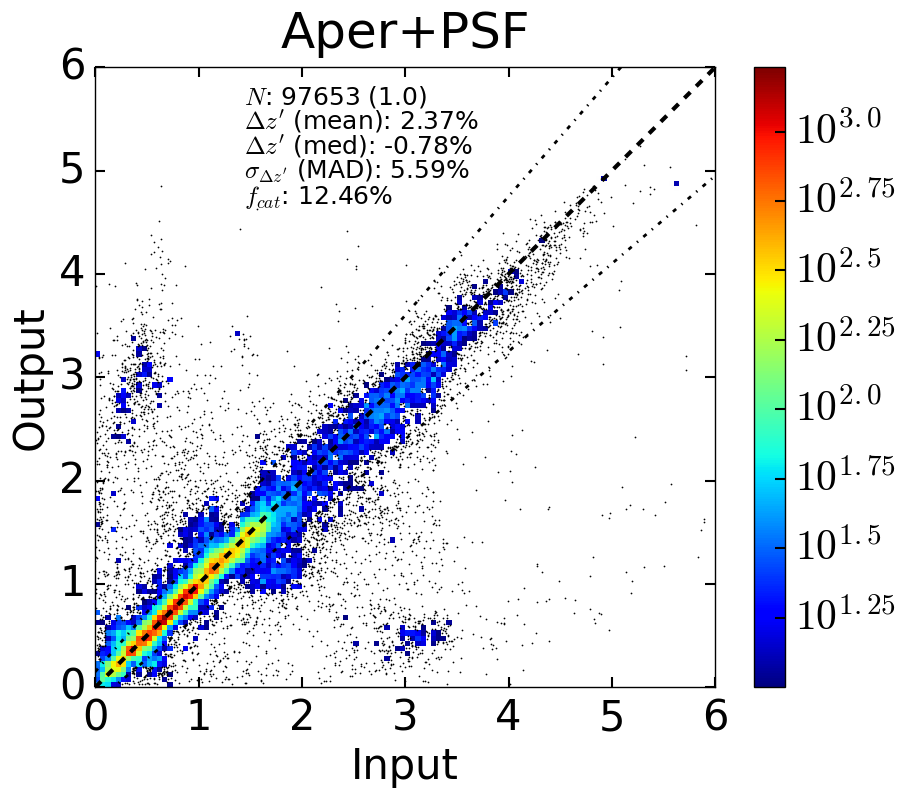

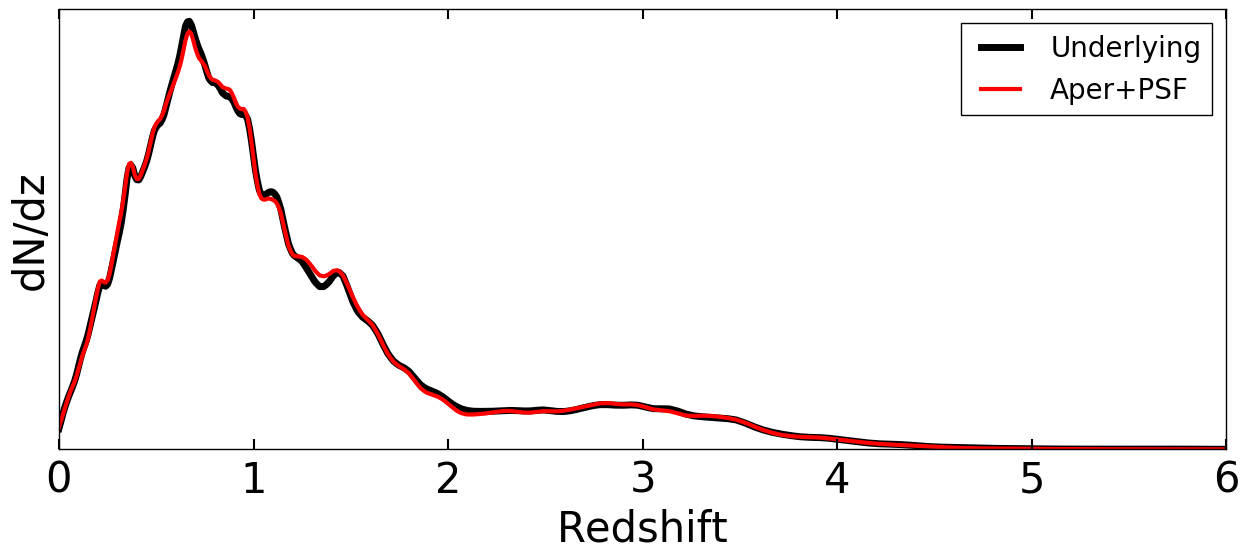

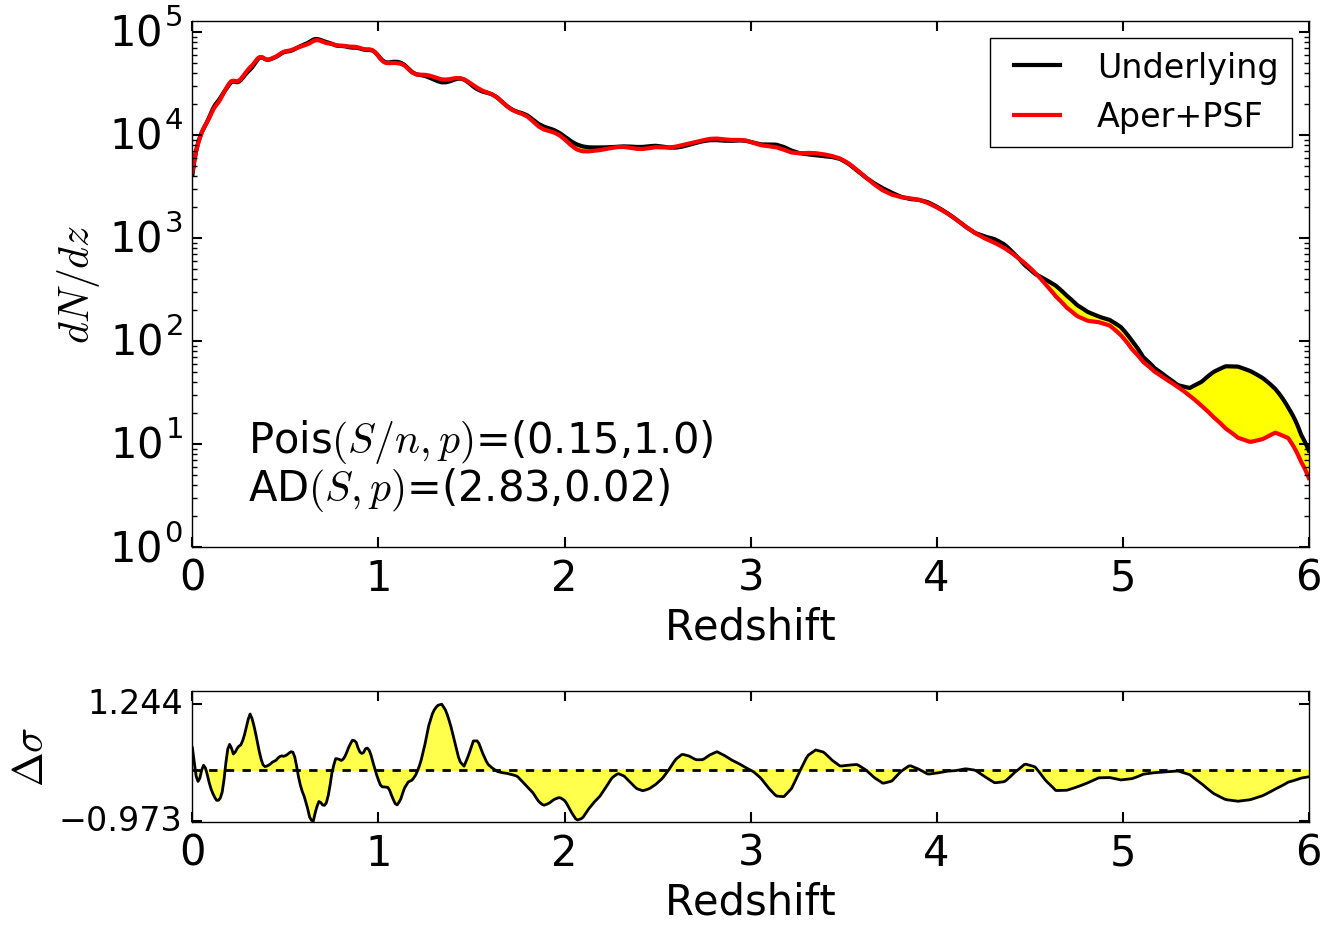

In [30]:
# plotting results
figure(figsize=(10,8))
fz.plot_zpoints('Aper+PSF',z[test_sel],zpoints[1],weights=cv_weights[test_sel])

figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test,lzeidx_test,cv_weights[test_sel],
                      rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

nz_stack=nansum(zpdf*cv_weights[test_sel][:,None],axis=0)/cv_weights[test_sel].sum()
plot(rdict.zgrid_out,nz_stack,lw=3,color='red',label='Aper+PSF')
xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
yticks([])
ylabel('dN/dz')

figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*cv_weights[test_sel].sum(),nz_stack*cv_weights[test_sel].sum(),rdict.zgrid_out,rdict.dz_out,
                       sample_names=['Underlying','Aper+PSF'],colors=['black','red'])

### Aper+PSF+Cdev+Cexp

In [31]:
temp1=c_[flux_afterburner,flux_psf,flux_cmodel_dev,flux_cmodel_exp]
temp2=c_[err_afterburner,err_psf,err_cmodel_dev,err_cmodel_exp]
temp2_wide=c_[err_cmodel_wide,err_psf_wide,err_cmodel_dev_wide,err_cmodel_exp_wide]
temp3=c_[mask_afterburner,mask_psf,mask_cmodel_dev,mask_cmodel_exp]
snoise=array([skynoise for i in xrange(4)]).flatten()

p1,v1,m1=temp1[train_sel],square(temp2[train_sel]),temp3[train_sel]
p2,v2,m2=temp1[test_sel],square(temp2_wide[test_sel]),temp3[test_sel]
e1,e2=sqrt(v1+square(0.01*p1)),sqrt(v2+square(0.01*p2)) # add 1% error floor

mag1,mage1=fz.asinh_mag_map(p1,e1,zeropoint=flux_zeropoint,skynoise=snoise) # Luptitude mapping
mag2,mage2=fz.asinh_mag_map(p2,e2,zeropoint=flux_zeropoint,skynoise=snoise) # Luptitude mapping

# initialize WINBET instances
winbet_train,winbet_test=fz.WINBET(Ntrees=25),fz.WINBET(Ntrees=25) # intialize WINBET (Ntrees=100,Nleaf=10)

if (m1==False).sum()>0:
    winbet_train.train(p1,v1,m1,mag1,mage1,mdict)
else:
    winbet_train=None
    
if (m2==False).sum()>0:
    winbet_test.train(p2,v2,m2,mag2,mage2,mdict)
else:
    winbet_test=None

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

In [32]:
frankenz=fz.FRANKENZ(N_members=25) # default values: N_MC=100, N_neighbors=10
model_obj,model_Nobj,model_ll,model_Nbands=frankenz.predict(p1,e1,m1,p2,e2,m2,subsample=arange(5),
                                                           impute_train=winbet_train,impute_test=winbet_test)

0 0 0 1 0 0 2 0 0 3 0 0 4 0 0 5 0 0 6 0 0 7 0 0 8 0 0 9 0 0 10 0 0 11 0 0 12 0 0 13 0 0 14 0 0 15 0 0 16 0 0 17 0 0 18 0 0 19 0 0 20 0 0 21 0 0 22 0 0 23 0 0 24 0 0 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!


In [33]:
# generate redshifts
model_llmin=empty(Ntest).astype(float)
lzpdf=empty((Ntest,rdict.Nz))
zpdf=empty((Ntest,rdict.Nz_out))
model_levidence=empty(Ntest)

for i in xrange(Ntest):
    if i%1000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    model_llmin[i]=ll.min() # minimum value (for scaling)
    w=exp(-0.5*(ll-model_llmin[i])) # transform to scaled likelihood weights
    model_levidence[i]=-2*log(w.sum())+model_llmin[i] # -2ln(Evidence)
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train[midx],lzeidx_train[midx],w,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[i]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# normalize PDFs
zpdf=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out)

# compute point estimates
zpoints=fz.pdfs_summary_statistics(rdict.zgrid_out,zpdf) # mean, med, mode, l68, h68, l95, h95, std, conf

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 Resampling PDFs...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!
Computing PDF quantities...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!


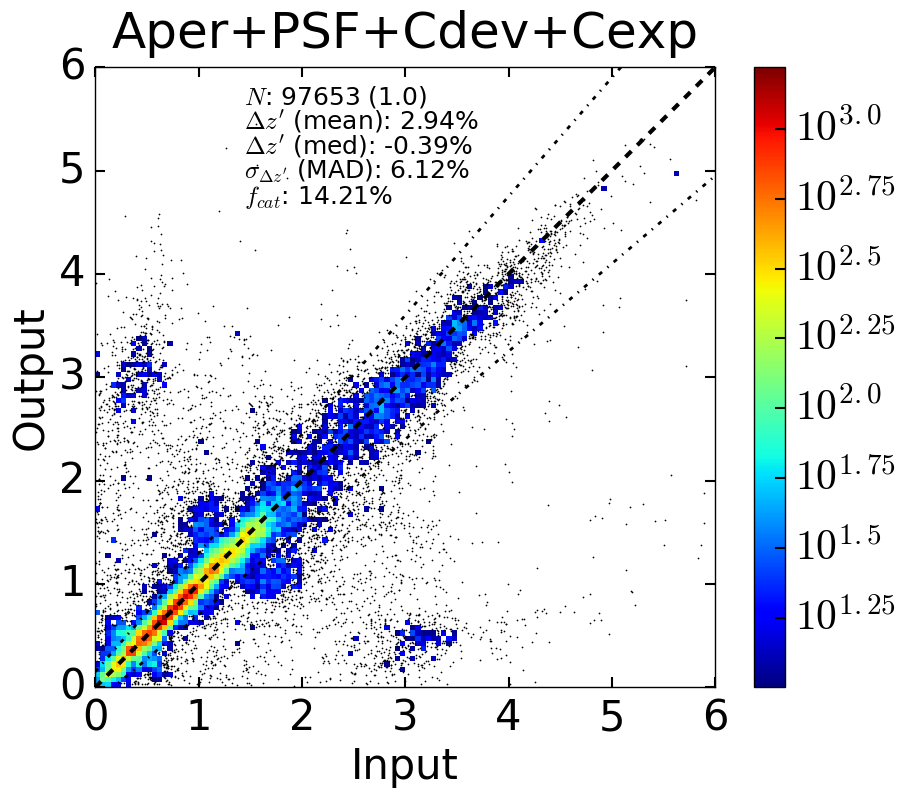

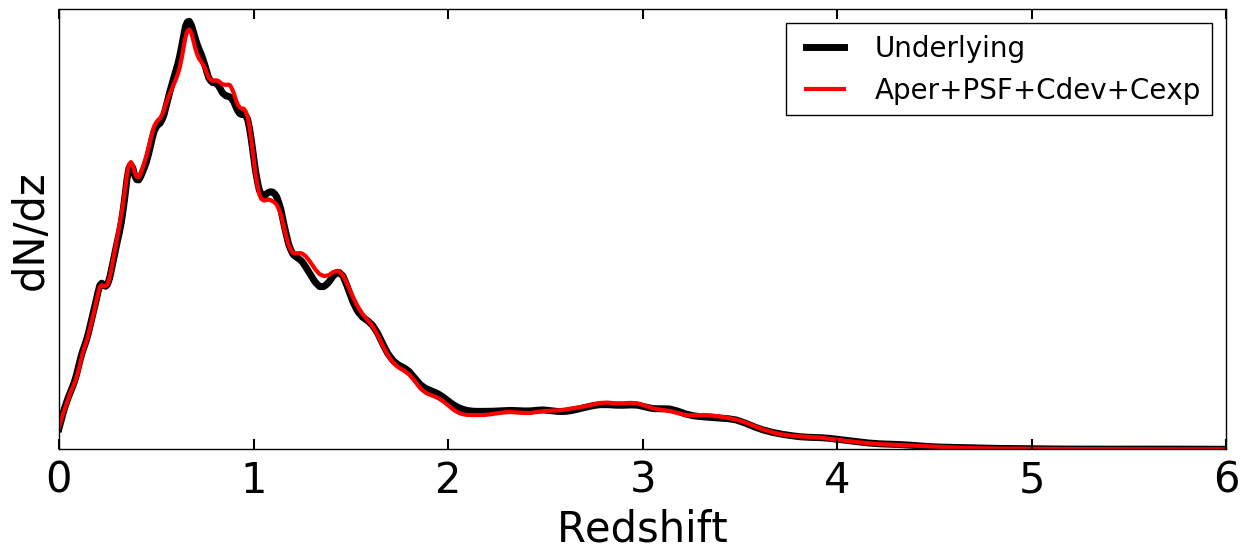

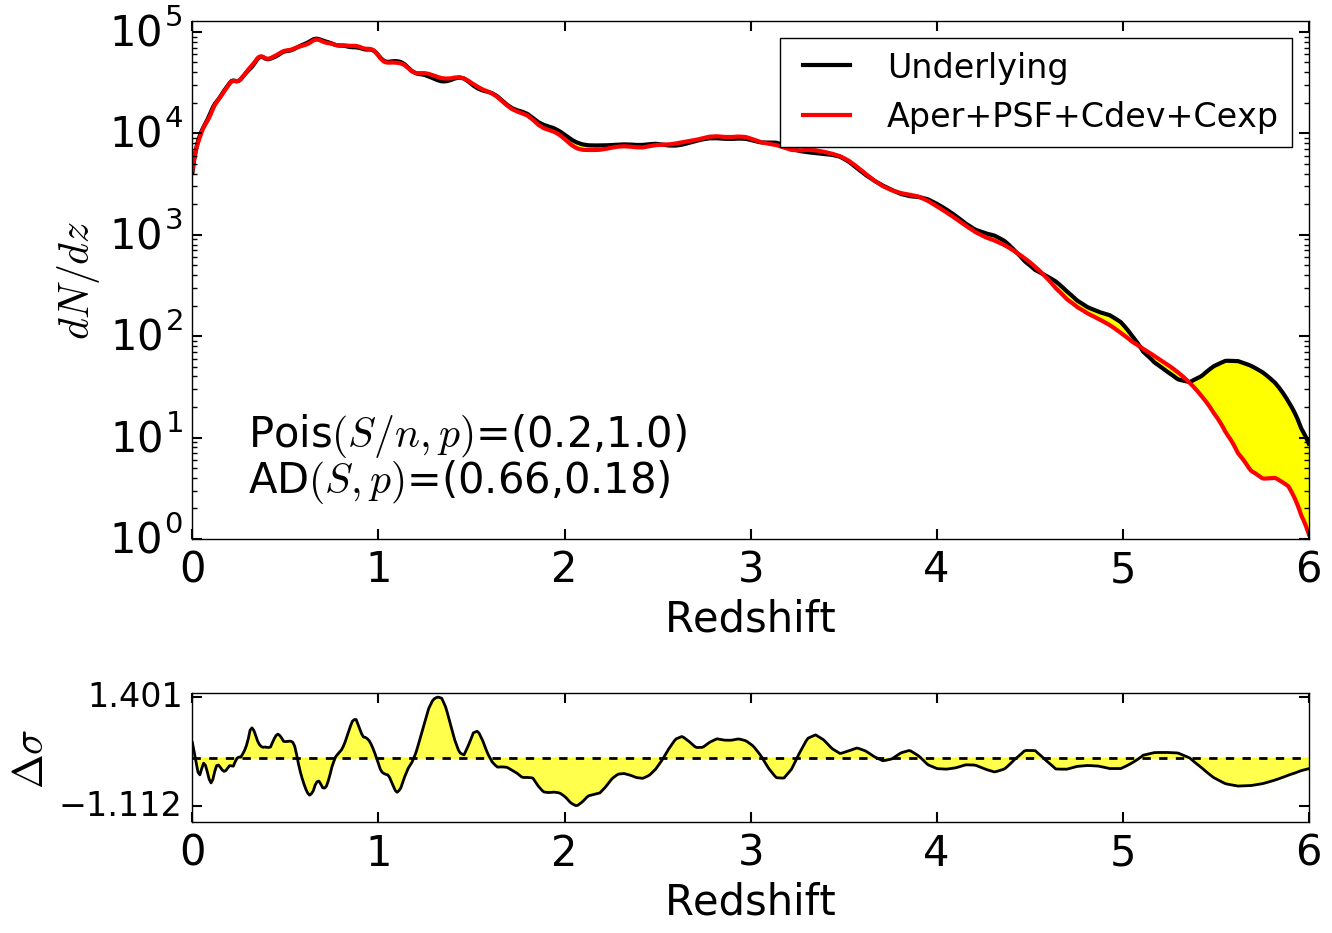

In [34]:
# plotting results
figure(figsize=(10,8))
fz.plot_zpoints('Aper+PSF+Cdev+Cexp',z[test_sel],zpoints[1],weights=cv_weights[test_sel])

figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test,lzeidx_test,cv_weights[test_sel],
                      rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

nz_stack=nansum(zpdf*cv_weights[test_sel][:,None],axis=0)/cv_weights[test_sel].sum()
plot(rdict.zgrid_out,nz_stack,lw=3,color='red',label='Aper+PSF+Cdev+Cexp')
xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
yticks([])
ylabel('dN/dz')

figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*cv_weights[test_sel].sum(),nz_stack*cv_weights[test_sel].sum(),rdict.zgrid_out,rdict.dz_out,
                       sample_names=['Underlying','Aper+PSF+Cdev+Cexp'],colors=['black','red'])

### Aper+PSF+Cdev+Cexp+Cmodel

In [35]:
temp1=c_[flux_afterburner,flux_psf,flux_cmodel_dev,flux_cmodel_exp,flux_cmodel]
temp2=c_[err_afterburner,err_psf,err_cmodel_dev,err_cmodel_exp,err_cmodel]
temp2_wide=c_[err_cmodel_wide,err_psf_wide,err_cmodel_dev_wide,err_cmodel_exp_wide,err_cmodel_wide]
temp3=c_[mask_afterburner,mask_psf,mask_cmodel_dev,mask_cmodel_exp,mask_cmodel]
snoise=array([skynoise for i in xrange(5)]).flatten()

p1,v1,m1=temp1[train_sel],square(temp2[train_sel]),temp3[train_sel]
p2,v2,m2=temp1[test_sel],square(temp2_wide[test_sel]),temp3[test_sel]
e1,e2=sqrt(v1+square(0.01*p1)),sqrt(v2+square(0.01*p2)) # add 1% error floor

mag1,mage1=fz.asinh_mag_map(p1,e1,zeropoint=flux_zeropoint,skynoise=snoise) # Luptitude mapping
mag2,mage2=fz.asinh_mag_map(p2,e2,zeropoint=flux_zeropoint,skynoise=snoise) # Luptitude mapping

# initialize WINBET instances
winbet_train,winbet_test=fz.WINBET(Ntrees=25),fz.WINBET(Ntrees=25) # intialize WINBET (Ntrees=100,Nleaf=10)

if (m1==False).sum()>0:
    winbet_train.train(p1,v1,m1,mag1,mage1,mdict)
else:
    winbet_train=None
    
if (m2==False).sum()>0:
    winbet_test.train(p2,v2,m2,mag2,mage2,mdict)
else:
    winbet_test=None

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

In [36]:
frankenz=fz.FRANKENZ(N_members=25) # default values: N_MC=100, N_neighbors=10
model_obj,model_Nobj,model_ll,model_Nbands=frankenz.predict(p1,e1,m1,p2,e2,m2,subsample=arange(5),
                                                           impute_train=winbet_train,impute_test=winbet_test)

0 0 0 1 0 0 2 0 0 3 0 0 4 0 0 5 0 0 6 0 0 7 0 0 8 0 0 9 0 0 10 0 0 11 0 0 12 0 0 13 0 0 14 0 0 15 0 0 16 0 0 17 0 0 18 0 0 19 0 0 20 0 0 21 0 0 22 0 0 23 0 0 24 0 0 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!


In [37]:
# generate redshifts
model_llmin=empty(Ntest).astype(float)
lzpdf=empty((Ntest,rdict.Nz))
zpdf=empty((Ntest,rdict.Nz_out))
model_levidence=empty(Ntest)

for i in xrange(Ntest):
    if i%1000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    model_llmin[i]=ll.min() # minimum value (for scaling)
    w=exp(-0.5*(ll-model_llmin[i])) # transform to scaled likelihood weights
    model_levidence[i]=-2*log(w.sum())+model_llmin[i] # -2ln(Evidence)
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train[midx],lzeidx_train[midx],w,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[i]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# normalize PDFs
zpdf=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out)

# compute point estimates
zpoints=fz.pdfs_summary_statistics(rdict.zgrid_out,zpdf) # mean, med, mode, l68, h68, l95, h95, std, conf

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 Resampling PDFs...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!
Computing PDF quantities...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 done!


C:\Users\Josh\Anaconda2\lib\site-packages\scipy\stats\morestats.py:1685: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


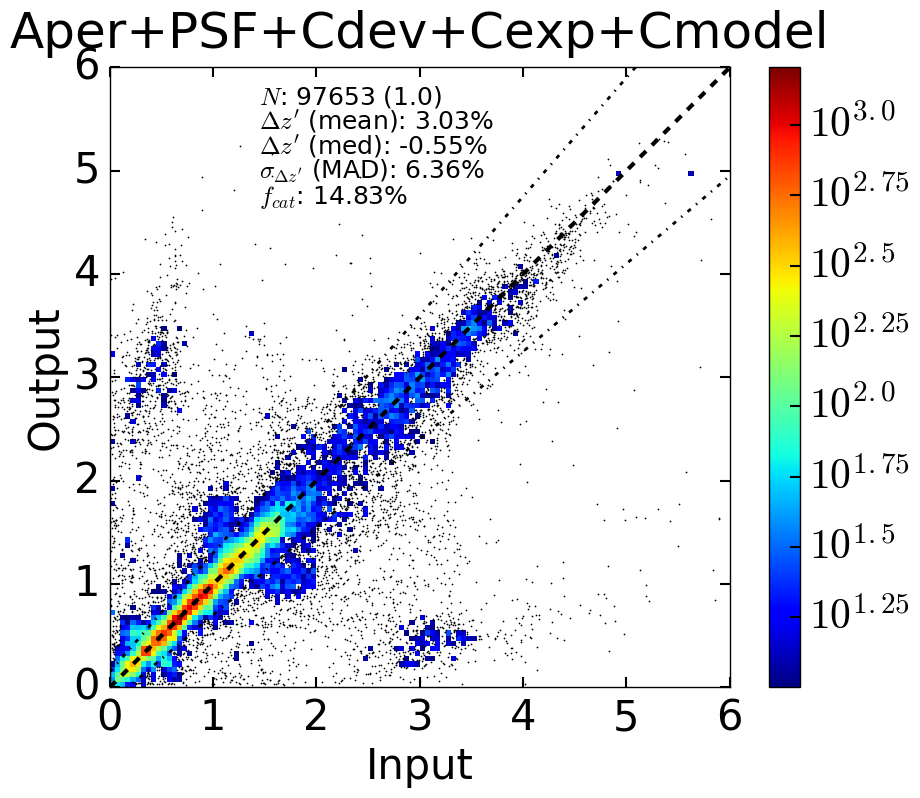

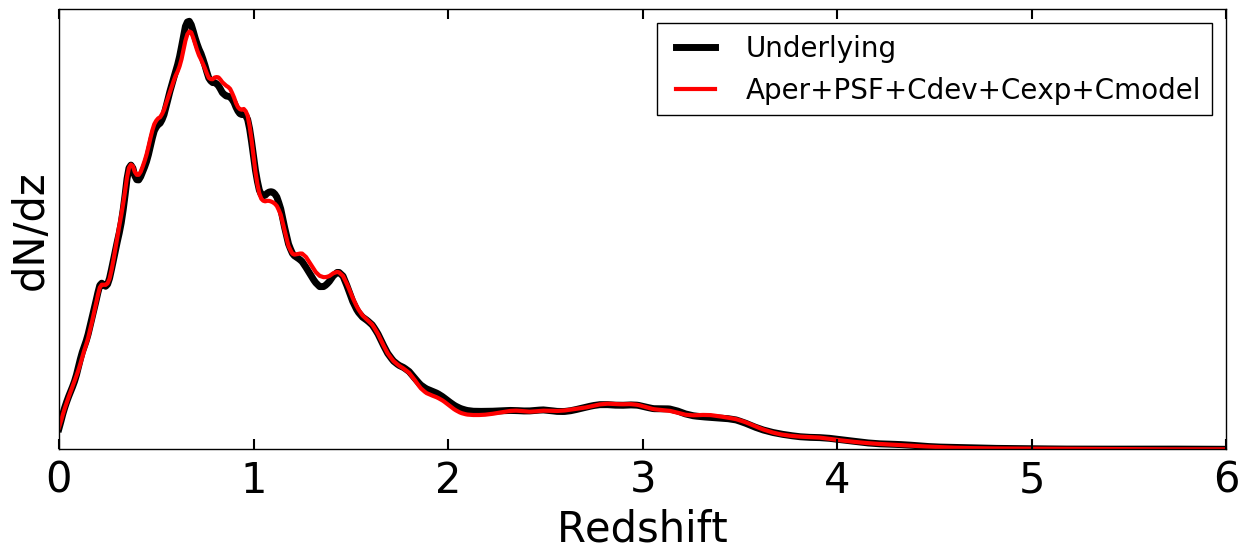

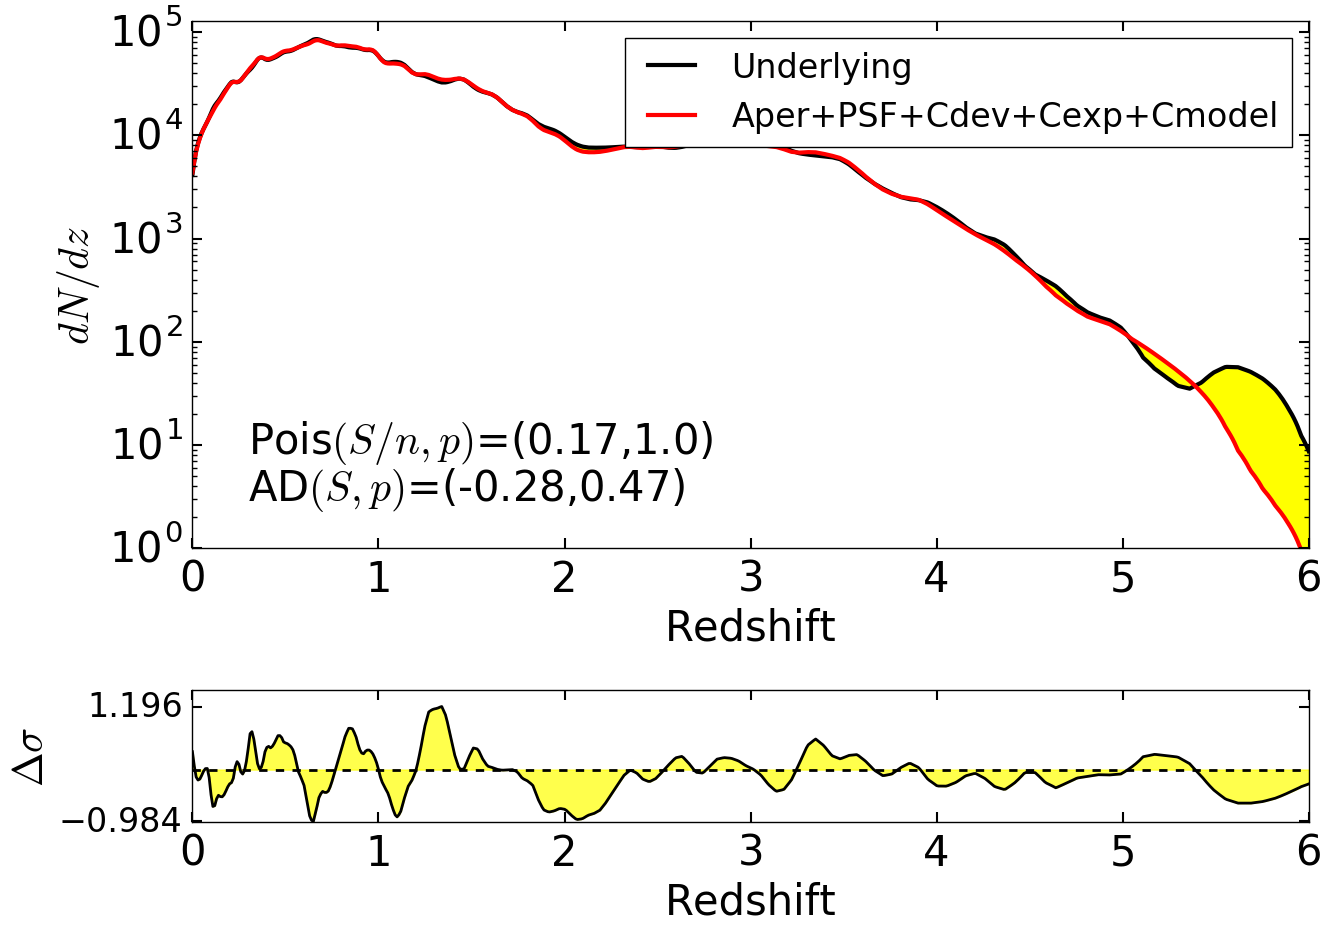

In [38]:
# plotting results
figure(figsize=(10,8))
fz.plot_zpoints('Aper+PSF+Cdev+Cexp+Cmodel',z[test_sel],zpoints[1],weights=cv_weights[test_sel])

figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test,lzeidx_test,cv_weights[test_sel],
                      rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

nz_stack=nansum(zpdf*cv_weights[test_sel][:,None],axis=0)/cv_weights[test_sel].sum()
plot(rdict.zgrid_out,nz_stack,lw=3,color='red',label='Aper+PSF+Cdev+Cexp+Cmodel')
xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
yticks([])
ylabel('dN/dz')

figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*cv_weights[test_sel].sum(),nz_stack*cv_weights[test_sel].sum(),rdict.zgrid_out,rdict.dz_out,
                       sample_names=['Underlying','Aper+PSF+Cdev+Cexp+Cmodel'],colors=['black','red'])

## Summary

While it's possible more sophisticated combinations of fluxes could improve on the psf-matched aperture photometry, it appears that adding more data adds more noise than information.